In [52]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from collections import defaultdict, deque
import time

# To draw the circuit
import networkx as nx
import matplotlib.pyplot as plt

# Circuit Model 1

Denote graph $G(V,E)$, where $v \in V$ are vertices and $e \in E$ are edges. Vertices $V$ do not include any blacked out cells and the set of edges $E$ are incident to two adjacent vertices. Let $e \in E$ be such that $e = (i,j)$ when edge $e$ is connecting vertex $i$ to vertex $j$, where $i < j$ and $i,j \in V$. Let $H$ be the set of edges given in the puzzle that must be in the solution. 

The decision variables for Circuit Model 1 are
$$
x_e = \begin{cases}
    1, & \text{ if edge } e \in E \text{  is included in the tree,} \\
    0, & \text{ otherwise, }
\end{cases}
$$
and the auxiliary binary variable
$$
y_i = \begin{cases}
    1, & \text{ if the degree of vertex } i\in V \text{ is } 3, \\
    0, & \text{ if the degree of vertex } i\in V \text{ is } 1.
\end{cases}
$$
The formulation is
$$
\begin{alignat}{2}
    \text{minimise} \ & \sum_{e \in E} x_e \\
    \text{subject to} \quad & x_e = 1 && \forall e \in H \\
    & \sum_{\{e\in E \ | \ i\in e\}} x_e = 1 + 2y_i && \forall i \in V \\
    & \sum_{e \in E} x_e = |V| -1 \\
    & \sum_{\{e = (i,j) \in E \ | i \in N\}} x_e \leq |N| - 1 \quad && \forall N \subset V, \ \emptyset \neq N \\
    & x_e \in \{0,1\} \ \forall e \in E, \\
    & y_i \in \{0,1\} \ \forall i \in V.
\end{alignat}
$$

In [21]:
def solvecircuit(n, blank, given_edges):
    # Start time
    start = time.time()

    # Create model
    model = gp.Model('Circuit')

    # Suppress output
    model.setParam('OutputFlag', 0)

    # Set time limit
    model.setParam(GRB.Param.TimeLimit, 1800)

    # Create vertices
    V = list(range(1,n**2 + 1))

    # Create a list that contains the feasible edges of G
    def edges(n):
        E = []
        for i in range(n):
            for j in range(n):
                current = i * n + j + 1
                if j < n - 1:
                    right = i * n + (j + 1) + 1
                    E.append((current, right))
                if i < n - 1:
                    below = (i + 1) * n + j + 1
                    E.append((current, below))
        return E

    E = edges(n)
    
    # Remove blank vertices and edges
    for b in blank:
        V.remove(b)
        E = [e for e in E if b not in e]
    
    # Number of vertices
    numV = len(V)
    numE = len(E)

    # Create the decision variables
    x = model.addVars(E, vtype=GRB.BINARY, name = 'x')
    
    y = model.addVars(V, vtype=GRB.BINARY, name = 'y')
    
    # Objective function is to minimise number of edges
    model.setObjective(gp.quicksum(x[e] for e in E), GRB.MINIMIZE)
    
    # Turn input into lower bounds to ensure they are included in the solution
    for e in given_edges:
        x[e].lb = 1
    
    # Constraint that requires all vertices have a degree of 1 or 3
    for i in V:
        # Find all edges connected to this vertex
        edges = [e for e in E if i in e]            
        model.addConstr(gp.quicksum(x[e] for e in edges) == 1 + 2*y[i], 'c1')
    
    # One of the constraints that ensure the solution forms a spanning tree: n-1 edges
    model.addConstr(gp.quicksum(x[e] for e in E) == len(V) - 1, 'c2')
    
    # Constraint that ensures that there are no cycles using subtour elimination inequalities using a callback
    def subtour_elimination(model, where):
        if where == GRB.Callback.MIPSOL:
            # Get the current solution
            selected_edges = [e for e in E if model.cbGetSolution(x[e]) > 0.5]
    
            # Find connected components    
            graph = defaultdict(list)
            for u, v in selected_edges:
                graph[u].append(v)
                graph[v].append(u)
    
            visited = set()
            components = []

            # Use breadth first search to detect cycles
            def bfs(node):
                queue = deque([node])
                component = []
                while queue:
                    curr = queue.popleft()
                    if curr not in visited:
                        visited.add(curr)
                        component.append(curr)
                        queue.extend(graph[curr])
                return component
    
            for v in V:
                if v not in visited:
                    components.append(bfs(v))
    
            # Add lazy constraints to stop the detected cycle from being included in the solution
            if len(components) > 1:
                for comp in components:
                    comp_edges = [e for e in E if e[0] in comp and e[1] in comp]
                    model.cbLazy(gp.quicksum(x[e] for e in comp_edges) <= len(comp) - 1)
    
    # Enable lazy constraints
    model.Params.LazyConstraints = 1
    
    # Solve the Circuit board game
    model.optimize(subtour_elimination)
    
    # Output solution
    print("|V| = ", numV, " |E| = ", numE)
    
    if model.status == GRB.OPTIMAL:
        solution_edges = [e for e in E if x[e].x > 0.5]
        
    # Extract results
    if model.SolCount > 0:
        best_upper_bound = model.ObjVal 
        best_lower_bound = model.ObjBound 
        optimality_gap = abs(best_upper_bound - best_lower_bound) / abs(best_upper_bound) * 100 if best_upper_bound != 0 else float('inf')
    
        print(f"Best Upper Bound: {best_upper_bound}")
        print(f"Best Lower Bound: {best_lower_bound}")
        print(f"Optimality Gap: {optimality_gap:.2f}%")

    end = time.time()
    totaltime = end - start

    print("Time: ", totaltime)
    print(" ")

    #return solution_edges

# Circuit Model 2

Denote graph $G(V,E)$, where $v \in V$ are vertices and $e \in E$ are edges. Vertices $V$ do not include any blacked out cells and the set of edges $E$ are incident to two adjacent vertices. Let $e \in E$ be such that $e = (i,j)$ when edge $e$ is connecting vertex $i$ to vertex $j$, where $i < j$ and $i,j \in V$. Let $a \in A$ be the possible arcs. Let $a \in A$ be such that $a = (i,j)$ when arc $a$ is connecting vertex $i$ to vertex $j$, $\forall i,j \in V$. Let $H$ be the set of edges given in the puzzle that must be in the solution. For the Big-M constraints let $M = 99$

The parameter $S_i$ represents the supply of vertex $i$. This is defined such that one vertex will have $S_i = |V| - 1$, and all other vertices will have $S_i = -1$.

The decision variables are $x_{ij} \in \mathbb{R}^+$, the flow over each arc $\forall (i,j) \in A$,
$$
z_{ij} = \begin{cases}
    1, & \text{ if either $x_{ij}$ or $x_{ji}$ is greater than 0}, \\
    0, & \text{ otherwise},
\end{cases} \quad \forall (i,j)\} \in E,
$$
and
$$
y_i = \begin{cases}
        1, & \text{ if the degree of vertex } i\in V \text{ is } 3, \\
        0, & \text{ if the degree of vertex } i\in V \text{ is } 1, 
\end{cases} \quad \forall i \in V.
$$
Circuit Model 2 is
$$
\begin{alignat}{2}
    \text{minimise } & \sum_{(i,j) \in E} z_{ij} \\
    \text{subject to } & \sum_{ (i,j) \in A} x_{ij} - \sum_{(j,i) \in A} x_{ji} = S_i && \forall i \in V \\
    & x_{ij} + x_{ji} \leq Mz_{ij} && \forall (i,j) \in E \\
    & M(x_{ij} + x_{ji}) \geq z_{ij} && \forall (i,j) \in E \\
    & \sum_{\{e \in E \ | \ i \in e\}} z_e = 1 + 2y_i && \forall i \in V \\
    & z_{ij} = 1 && \forall (i,j) \in H \\
    & x_{ij} \in \mathbb{R}^+ \ \forall i,j \in V, \ z_{ij} \in \{0,1\} \ \forall i,j \in V, \\ 
    & y_i \in \{0,1\} \ \forall i \in V .
\end{alignat}
$$

In [5]:
def NEOScircuit(n, blank, given_edges):
    # Start time
    start = time.time()
    
    # Create model
    model = gp.Model('NEOSModel')

    # Suppress output
    model.setParam('OutputFlag', 0)

    # Set time limit
    model.setParam(GRB.Param.TimeLimit, 1800)

    # Create vertices
    V = list(range(1,n**2 + 1))

    # Big-M variable, chosen using justification provided in the report
    M = 99
    
    # Generate all edges
    def edges(n):
        A = []
        for i in range(n):
            for j in range(n): 
                current = i * n + j + 1
                if j < n - 1:
                    right = i * n + (j + 1) + 1
                    A.append((current, right))
                if i < n - 1:
                    below = (i + 1) * n + j + 1
                    A.append((current, below))
        return A
    
    E = edges(n)
    
    # Remove blank arcs
    for b in blank:
        V.remove(b)
        E = [e for e in E if b not in e]

    numV = len(V)
    numE = len(E)
    
    # Reverse order to represent the flow of each arc
    def reverseTuple(E):
        return [tup[::-1] for tup in E]
    
    Einv = reverseTuple(E)

    # Define all arcs 
    A = E.copy()
    for a in Einv:
        A.append(a)
    
    def generate_S(n, blank):
        total_cells = n**2

        # All but one vertex has supply vertex -1
        S = {v: -1 for v in range(1, total_cells + 1)}  
    
        # Blocked cells have supply 0
        for b in blank:
            S[b] = 0
    
        # Set up the source vertex
        unblocked_cells = [v for v in range(1, total_cells + 1) if v not in blank]
        if unblocked_cells:
            source_vertex = unblocked_cells[0]
            S[source_vertex] = len(unblocked_cells) - 1
        return S
    
    S = generate_S(n, blank)
    
    # Decision variables
    x = model.addVars(A, vtype=GRB.CONTINUOUS, name="x")
    z = model.addVars(E, vtype=GRB.BINARY, name="z")
    t = model.addVars(V, vtype=GRB.INTEGER, name="t")
    
    # Objective function is to minimise number of edges
    model.setObjective(gp.quicksum(z[e] for e in E), GRB.MINIMIZE)

    # Flow conservation equations
    for i in V:
        a = gp.quicksum(x[arc] for arc in A if arc[0] == i)
        b = gp.quicksum(x[arc] for arc in A if arc[1] == i)
        model.addConstr(a - b == S[i], 'c1')
    
    # Relate arcs to edges. Edges must be turned on if flow is passing through as assosiated arc
    for e in E:
        model.addConstr(x[e] + x[e[1], e[0]] <= z[e] * M, 'c2')
        model.addConstr(M*(x[e] + x[e[1], e[0]]) >= z[e] , 'c3')

    # Ensure each vertex has degree either 1 or 3
    for i in V:
        # Find all edges connected to this vertex
        edges = [e for e in E if i in e]
        model.addConstr(gp.quicksum(z[e] for e in edges) == 1 + 2 * t[i], 'c4')
    
    # Given edges set as lower bounds
    for e in given_edges:
        z[e].lb = 1
    
    # Solve model
    model.optimize()
    
    # Output solution
    print("|V| = ", numV, " |E| = ", numE)
    
    if model.status == GRB.OPTIMAL:
        solution_edges = [e for e in E if z[e].x > 0.5]


    # Extract results
    if model.SolCount > 0:
        best_upper_bound = model.ObjVal  
        best_lower_bound = model.ObjBound  
        optimality_gap = abs(best_upper_bound - best_lower_bound) / abs(best_upper_bound) * 100 if best_upper_bound != 0 else float('inf')
    
        print(f"Best Upper Bound: {best_upper_bound}")
        print(f"Best Lower Bound: {best_lower_bound}")
        print(f"Optimality Gap: {optimality_gap:.2f}%")

    end = time.time()
    totaltime = end - start

    print("Time: ", totaltime)
    print(" ")

    #return solution_edges

In [7]:
def graphcircuit(n, blank, solution_edges):

    # Create vertices
    V = list(range(1,n**2 + 1))
    
    G = nx.Graph()
    pos = {}
        
    # Add nodes and position them based on grid coordinates
    for v in V:
        row = (v - 1) // n
        col = (v - 1) % n
        G.add_node(v, pos=(col, -row))  
        pos[v] = (col, -row)
        
    # Add edges from the solution
    G.add_edges_from(solution_edges)
        
    # Create grid of blank squares
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    
    # Draw the grid
    for i in range(n):
        for j in range(n):
            rect = plt.Rectangle((j - 0.5, -i - 0.5), 1, 1, facecolor="white", edgecolor="gray", linewidth=1)
            ax.add_patch(rect)
    
    # Colour the black cells
    for b in blank:
        row = (b - 1) // n
        col = (b - 1) % n
        rect = plt.Rectangle((col - 0.5, -row - 0.5), 1, 1, facecolor="black", edgecolor="gray", linewidth=1)
        ax.add_patch(rect)
    
    # Draw the circuit
    nx.draw(G, pos, with_labels=False, node_color="black", edge_color="black", node_size=200, font_size=10)
    plt.xlim(-1, n)
    plt.ylim(-n, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [7]:
# All puzzles tested
n = [3,3,3,3,3,4,4,4,4,4,5,5,5,5,5,6,6,6,6,6,7,7,7,7,7,8,8,8,8,8,9,9,9,9,9,10,10,10,10,10]
blank = [[1,2,3],[6],[4,7,9],[1,3,7,8,9],[2,3,6,8,9],
         [3,4],[13,16],[1,3,4,8],[1,3,4,13,15,16],[1,2,6,16],
         [16,21,25],[23,24,25],[1,2,6,11,16],[1,24,25],[4,5,16,21,22],
         [1,2],[1,2,3,4,5,6],[6,18,30,36],[1,2,7,8,35,36],[20,21],
         [1,2,3,4,5,6,7],[14],[30,31,32,48,49],[1,2,49],[17,24,35,41,42,48,49],
         [1,8],[63,64],[1,2,28,29,34,35],[8,28,29,36,37,64],[19,27],
         [1,2,10,80,81],[9,64,73],[39,40,41],[9,48,57],[21,22,50,51,52],
         [99,100],[1,2,3,8,9,10],[45,46],[45,46,55,56,91,100],[1,9,91,100]]
given_edges = [[(8,9)],[(2,5)],[(2,3)],[(4,5)],[(4,7)],
               [(7,11),(10,11)],[(9,10),(10,11)],[(2,6)],[(7,11)],[(9,13)],
               [(9,14),(14,15)],[(7,12),(13,18)],[(14,15)],[(4,9),(14,19)],[(1,2),(24,25)],
               [(15,21),(22,28)],[(7,13),(30,36)],[(20,21),(21,22)],[(20,21),(22,23)],[(19,25)],
               [(14,21)],[(40,41)],[(1,8)],[(9,16),(16,23)],[(1,2)],
               [(35,36)],[(1,2)],[(31,39),(39,47)],[(57,58)],[(16,24)],
               [(9,18)],[(23,32),(33,42)],[(57,66)],[(35,36)],[(17,26)],
               [(1,11)],[(58,59)],[(84,85)],[(10,20)],[(52,53)]] 

Circuit Model 1: 
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-07
|V| =  6  |E| =  7
Best Upper Bound: 5.0
Best Lower Bound: 5.0
Optimality Gap: 0.00%
Time:  0.015647411346435547
 


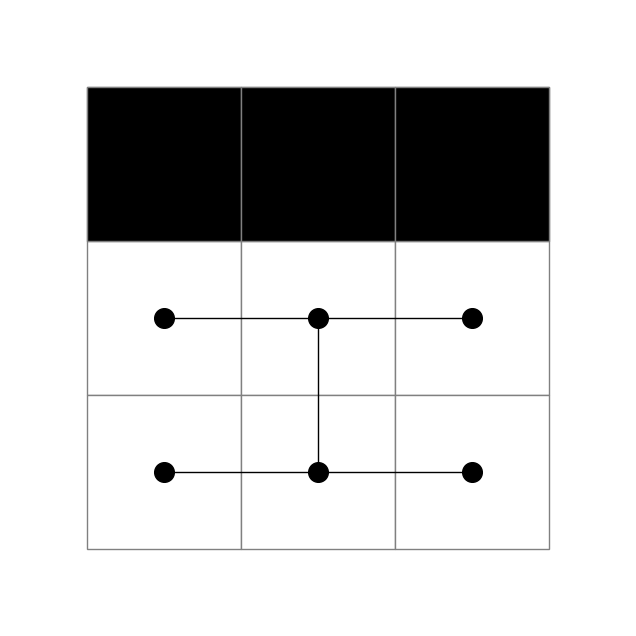

Circuit Model 2: 
|V| =  6  |E| =  7
Best Upper Bound: 5.0
Best Lower Bound: 5.0
Optimality Gap: 0.00%
Time:  0.0
 


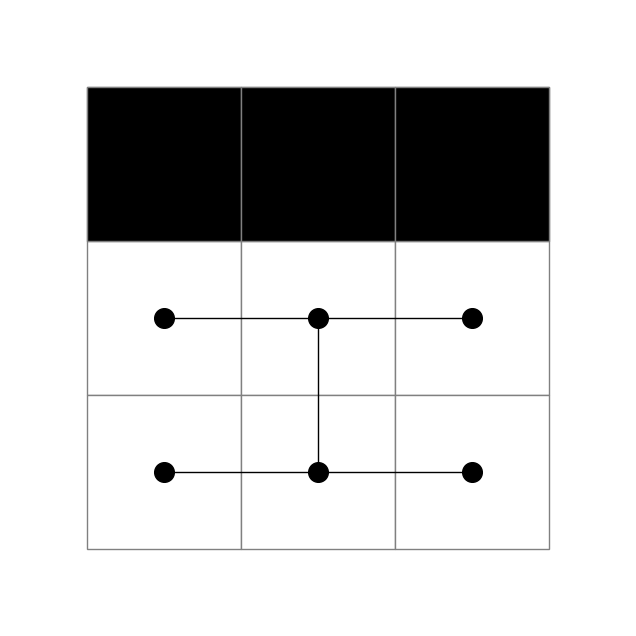

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  8  |E| =  9
Best Upper Bound: 7.0
Best Lower Bound: 7.0
Optimality Gap: 0.00%
Time:  0.0
 


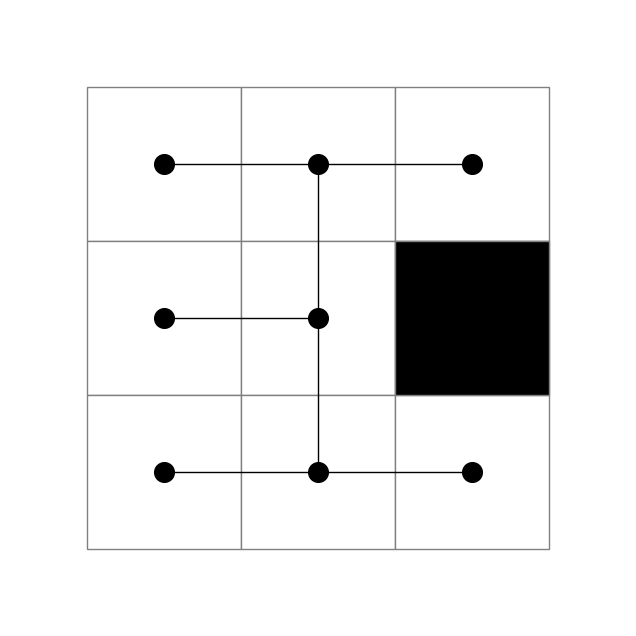

Circuit Model 2: 
|V| =  8  |E| =  9
Best Upper Bound: 7.0
Best Lower Bound: 7.0
Optimality Gap: 0.00%
Time:  0.0
 


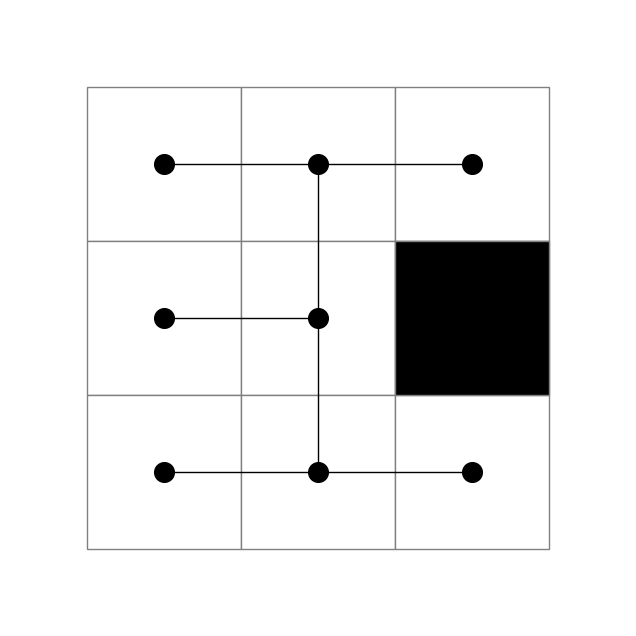

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  6  |E| =  6
Best Upper Bound: 5.0
Best Lower Bound: 5.0
Optimality Gap: 0.00%
Time:  0.0
 


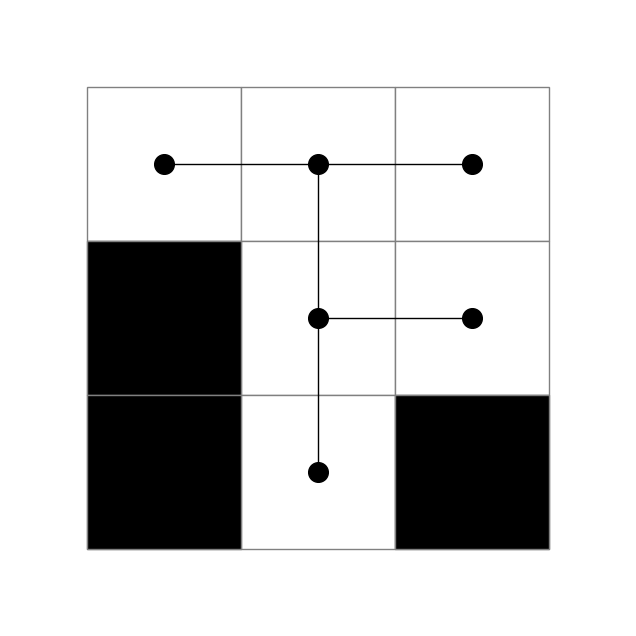

Circuit Model 2: 
|V| =  6  |E| =  6
Best Upper Bound: 5.0
Best Lower Bound: 5.0
Optimality Gap: 0.00%
Time:  0.0
 


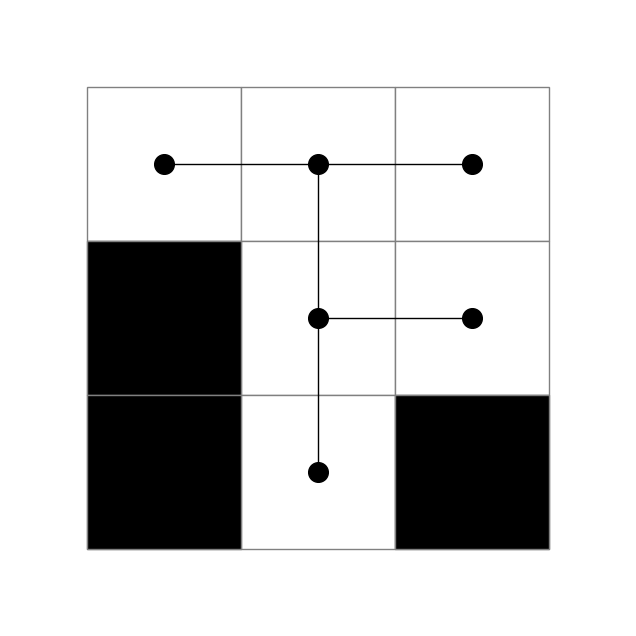

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  4  |E| =  3
Best Upper Bound: 3.0
Best Lower Bound: 3.0
Optimality Gap: 0.00%
Time:  0.0
 


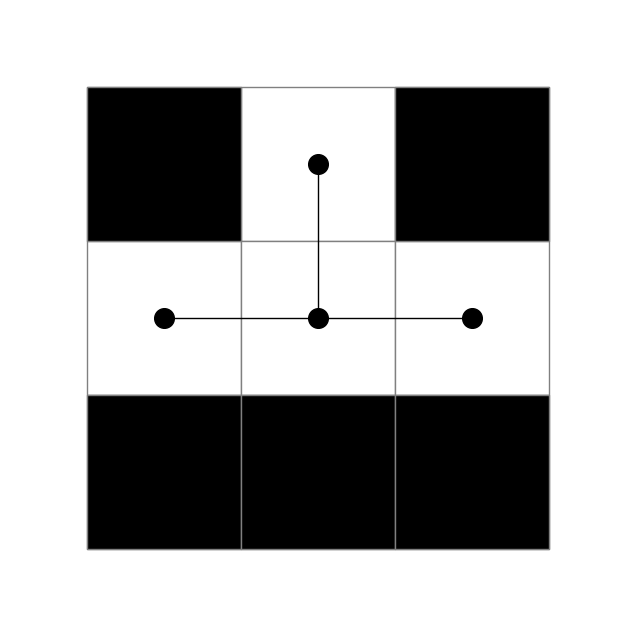

Circuit Model 2: 
|V| =  4  |E| =  3
Best Upper Bound: 3.0
Best Lower Bound: 3.0
Optimality Gap: 0.00%
Time:  0.0
 


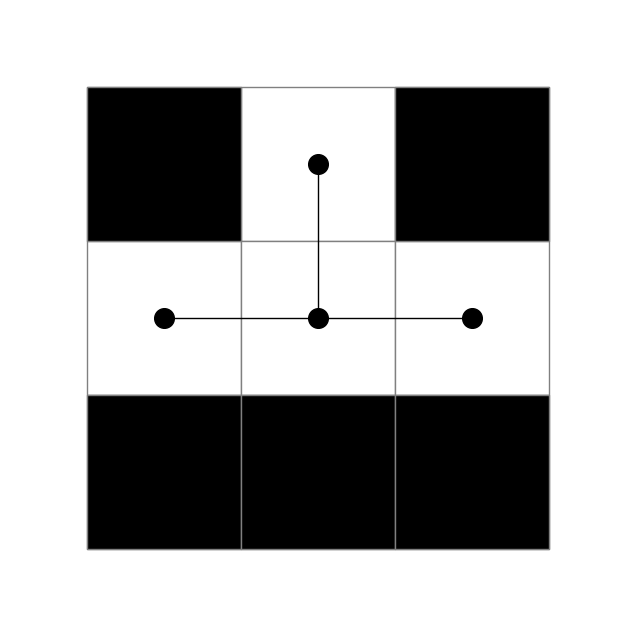

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  4  |E| =  3
Best Upper Bound: 3.0
Best Lower Bound: 3.0
Optimality Gap: 0.00%
Time:  0.0
 


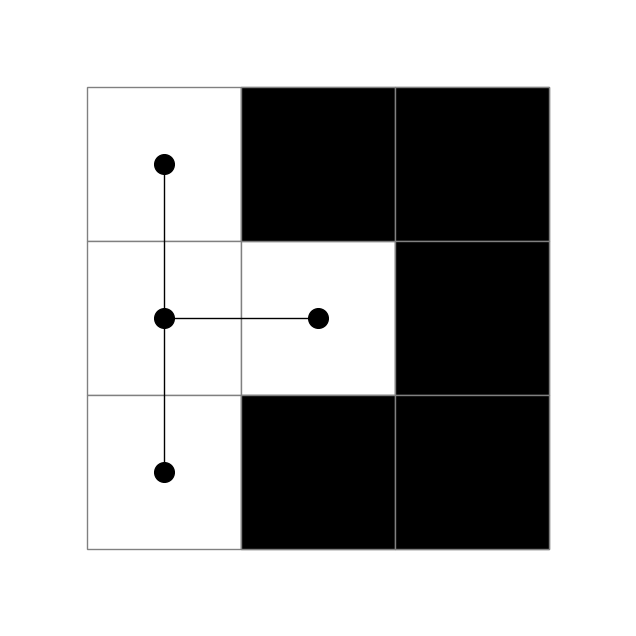

Circuit Model 2: 
|V| =  4  |E| =  3
Best Upper Bound: 3.0
Best Lower Bound: 3.0
Optimality Gap: 0.00%
Time:  0.0
 


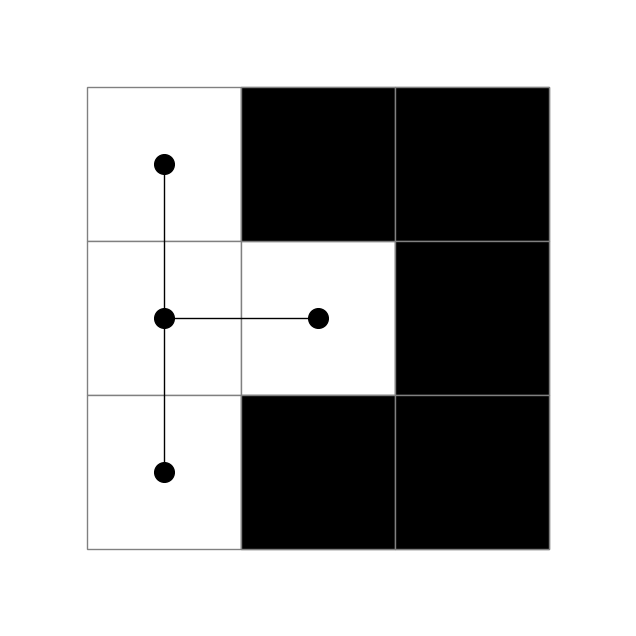

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  14  |E| =  20
Best Upper Bound: 13.0
Best Lower Bound: 13.0
Optimality Gap: 0.00%
Time:  0.0
 


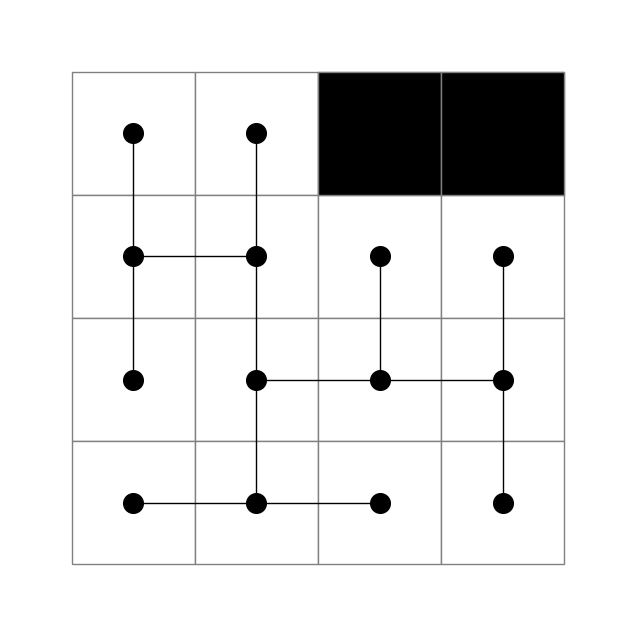

Circuit Model 2: 
|V| =  14  |E| =  20
Best Upper Bound: 13.0
Best Lower Bound: 13.0
Optimality Gap: 0.00%
Time:  0.015621185302734375
 


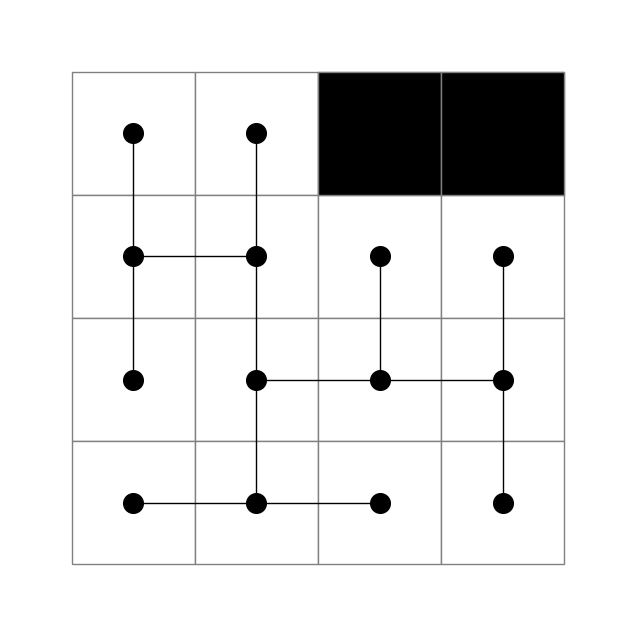

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  14  |E| =  20
Best Upper Bound: 13.0
Best Lower Bound: 13.0
Optimality Gap: 0.00%
Time:  0.01574540138244629
 


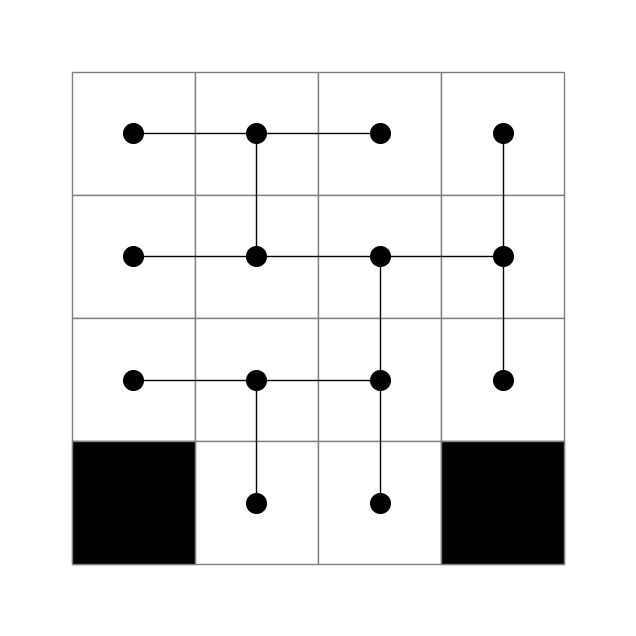

Circuit Model 2: 
|V| =  14  |E| =  20
Best Upper Bound: 13.0
Best Lower Bound: 13.0
Optimality Gap: 0.00%
Time:  0.0
 


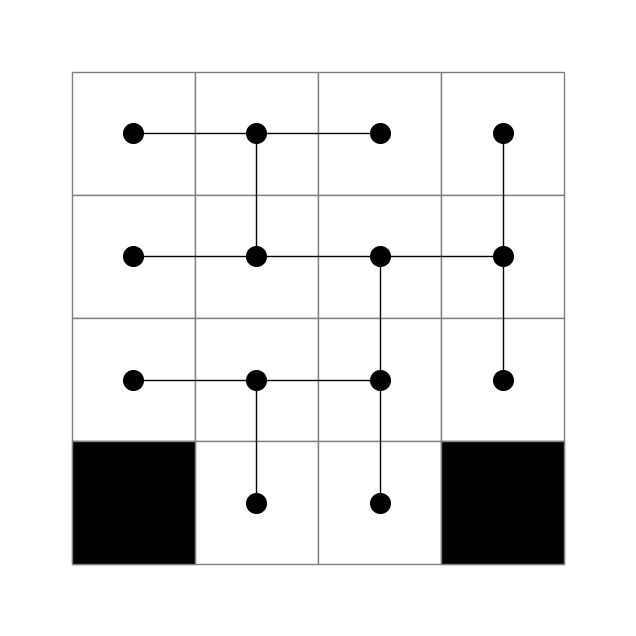

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  12  |E| =  16
Best Upper Bound: 11.0
Best Lower Bound: 11.0
Optimality Gap: 0.00%
Time:  0.0
 


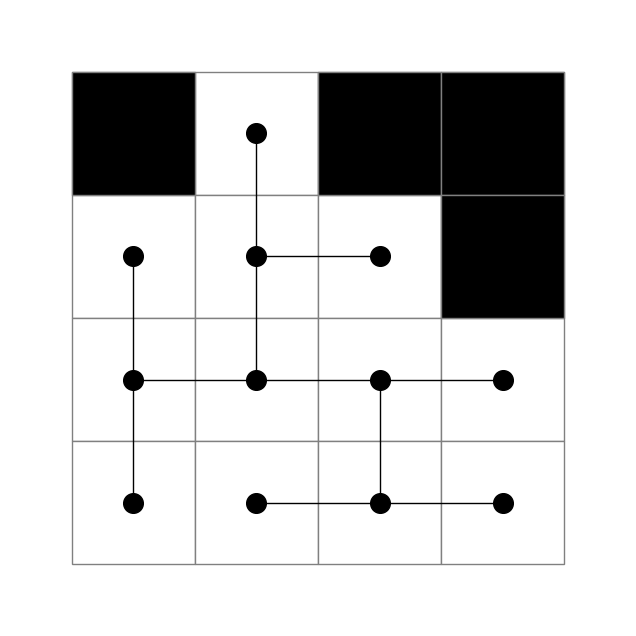

Circuit Model 2: 
|V| =  12  |E| =  16
Best Upper Bound: 11.0
Best Lower Bound: 11.0
Optimality Gap: 0.00%
Time:  0.015511751174926758
 


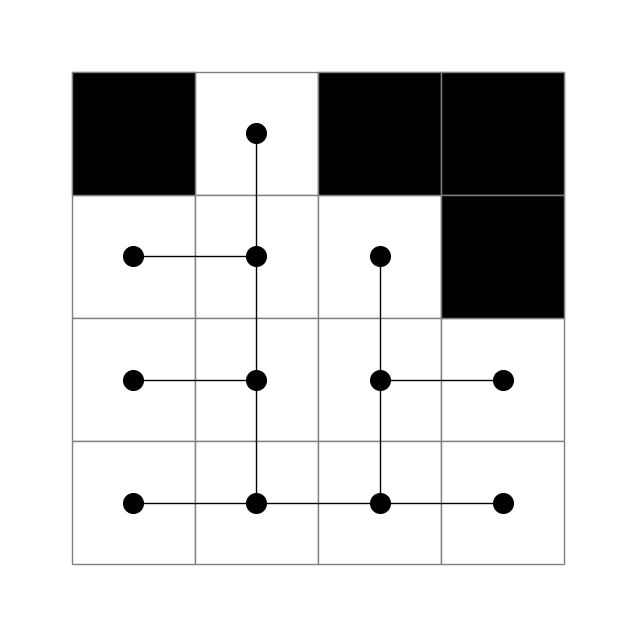

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  10  |E| =  12
Best Upper Bound: 9.0
Best Lower Bound: 9.0
Optimality Gap: 0.00%
Time:  0.0055162906646728516
 


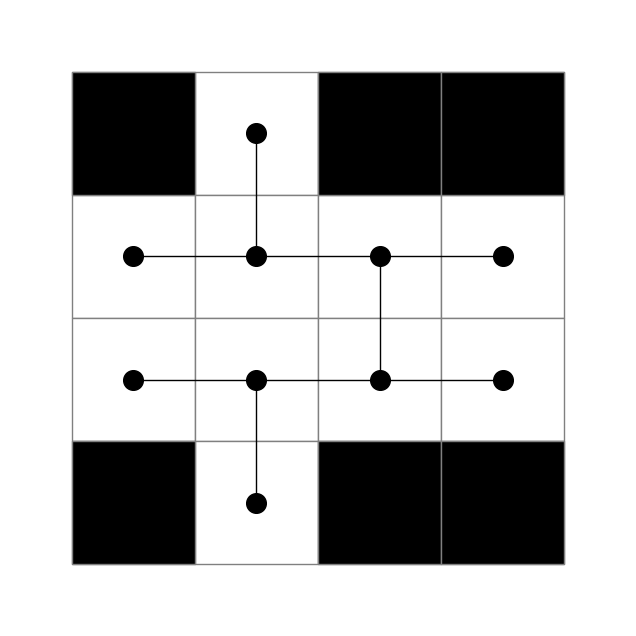

Circuit Model 2: 
|V| =  10  |E| =  12
Best Upper Bound: 9.0
Best Lower Bound: 9.0
Optimality Gap: 0.00%
Time:  0.01562047004699707
 


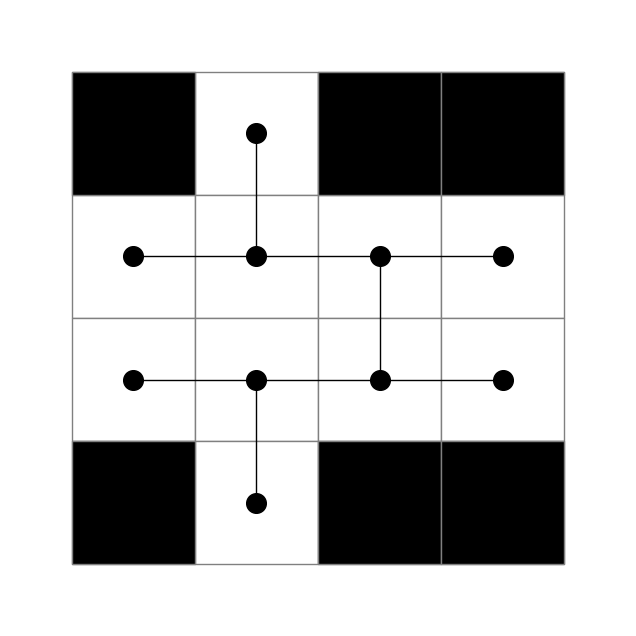

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  12  |E| =  15
Best Upper Bound: 11.0
Best Lower Bound: 11.0
Optimality Gap: 0.00%
Time:  0.0156252384185791
 


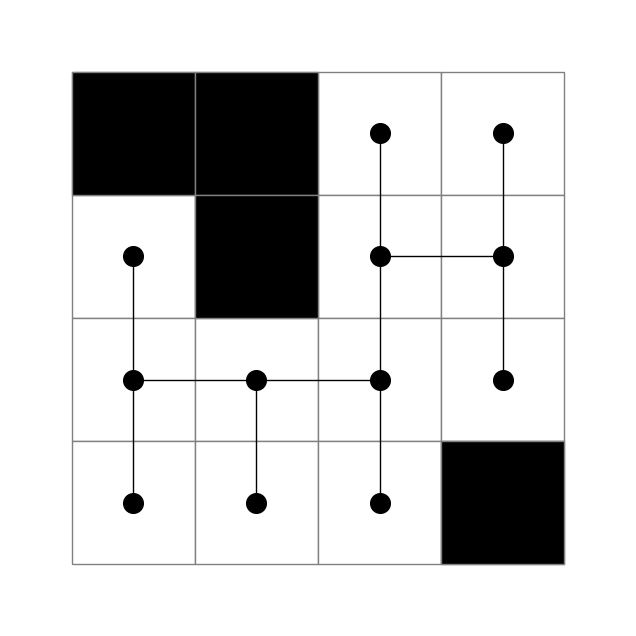

Circuit Model 2: 
|V| =  12  |E| =  15
Best Upper Bound: 11.0
Best Lower Bound: 11.0
Optimality Gap: 0.00%
Time:  0.0
 


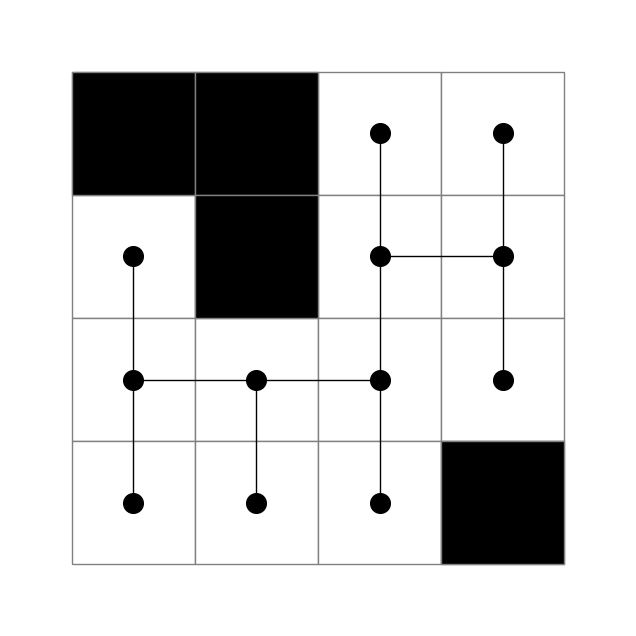

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  22  |E| =  34
Best Upper Bound: 21.0
Best Lower Bound: 21.0
Optimality Gap: 0.00%
Time:  0.0
 


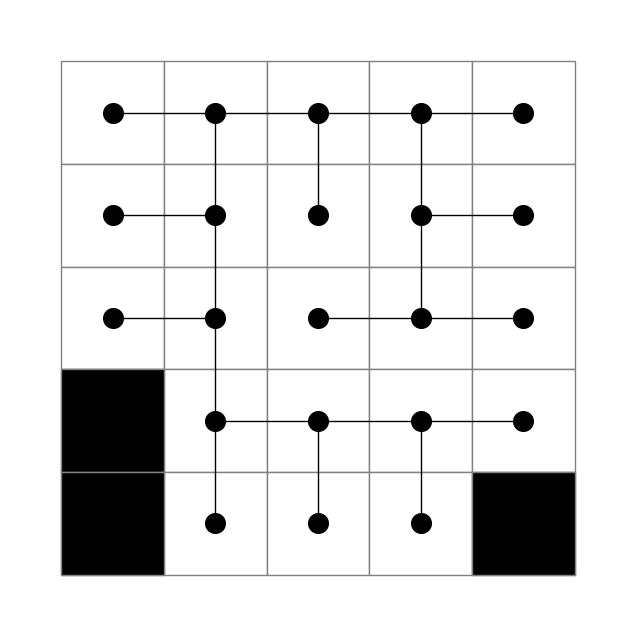

Circuit Model 2: 
|V| =  22  |E| =  34
Best Upper Bound: 21.0
Best Lower Bound: 21.0
Optimality Gap: 0.00%
Time:  0.07964944839477539
 


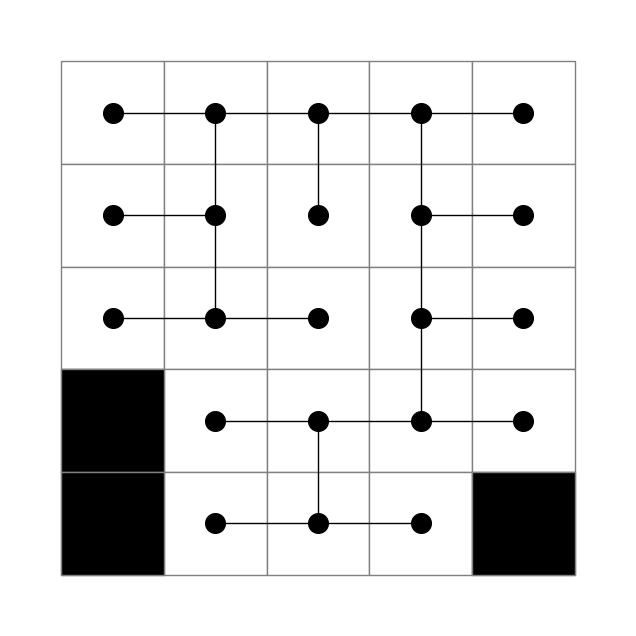

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  22  |E| =  34
Best Upper Bound: 21.0
Best Lower Bound: 21.0
Optimality Gap: 0.00%
Time:  0.0
 


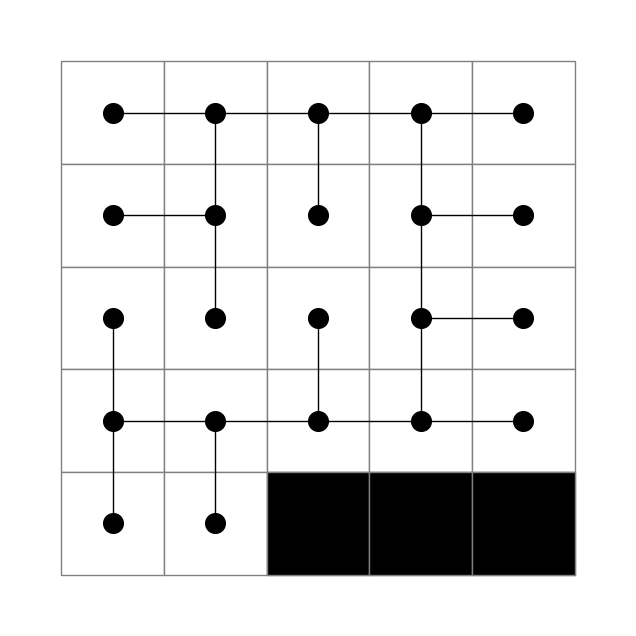

Circuit Model 2: 
|V| =  22  |E| =  34
Best Upper Bound: 21.0
Best Lower Bound: 21.0
Optimality Gap: 0.00%
Time:  0.030846595764160156
 


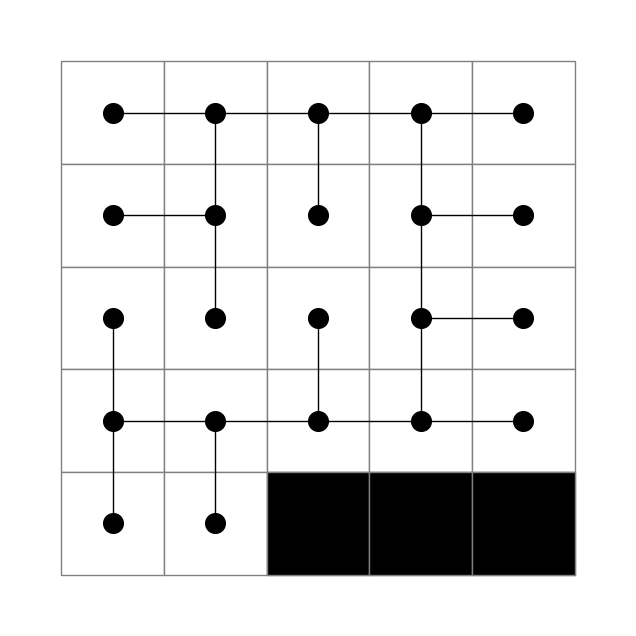

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  20  |E| =  30
Best Upper Bound: 19.0
Best Lower Bound: 19.0
Optimality Gap: 0.00%
Time:  0.0
 


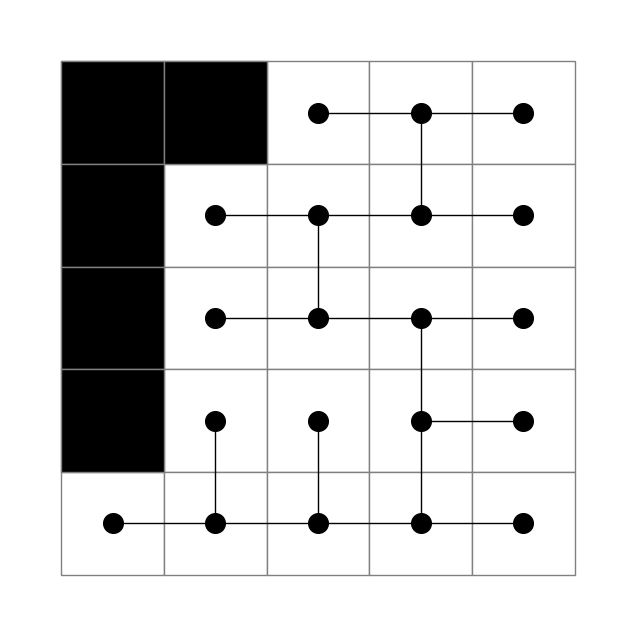

Circuit Model 2: 
|V| =  20  |E| =  30
Best Upper Bound: 19.0
Best Lower Bound: 19.0
Optimality Gap: 0.00%
Time:  0.04690408706665039
 


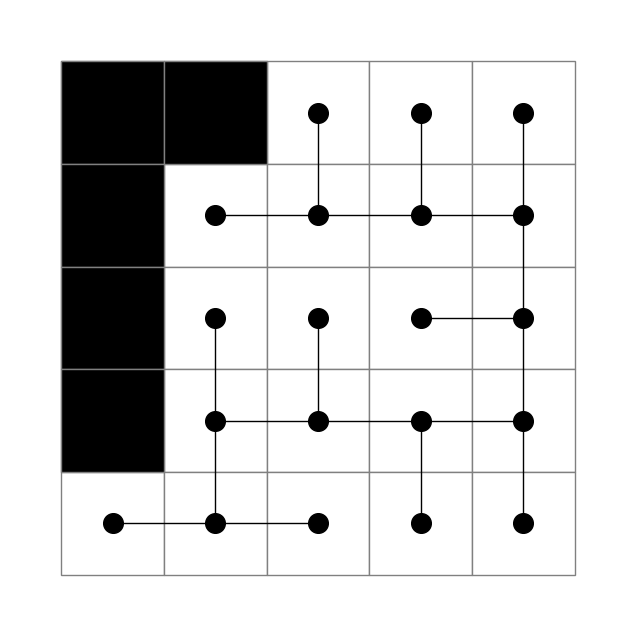

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  22  |E| =  34
Best Upper Bound: 21.0
Best Lower Bound: 21.0
Optimality Gap: 0.00%
Time:  0.0
 


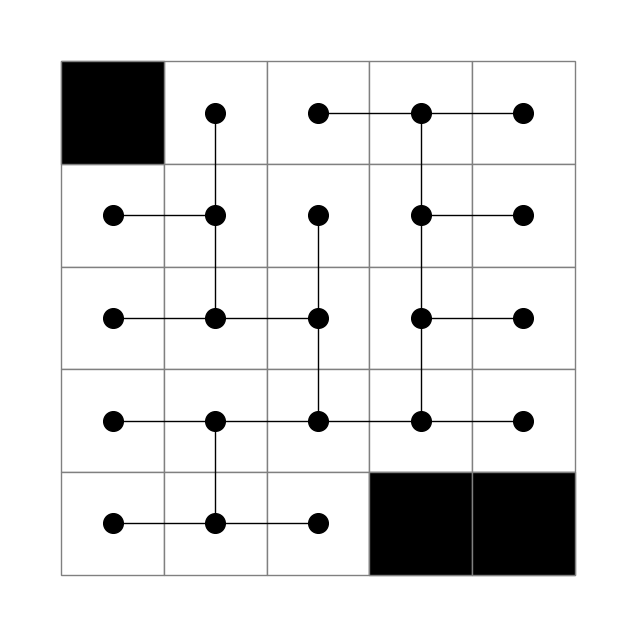

Circuit Model 2: 
|V| =  22  |E| =  34
Best Upper Bound: 21.0
Best Lower Bound: 21.0
Optimality Gap: 0.00%
Time:  0.12586283683776855
 


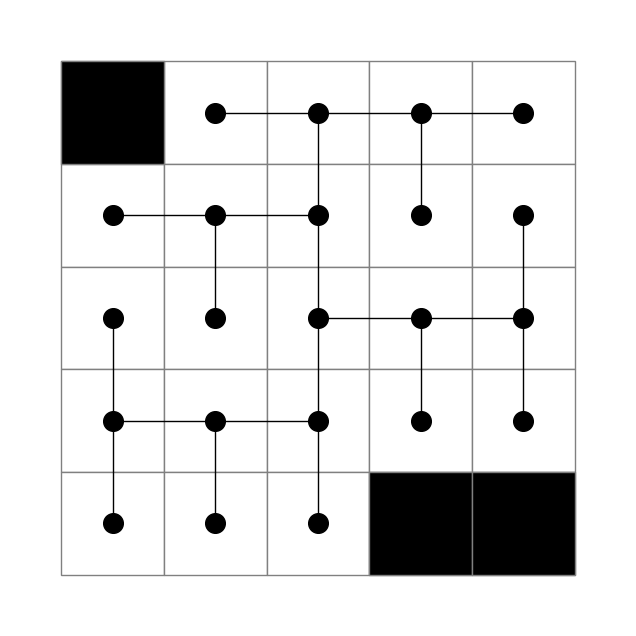

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  20  |E| =  30
Best Upper Bound: 19.0
Best Lower Bound: 19.0
Optimality Gap: 0.00%
Time:  0.0
 


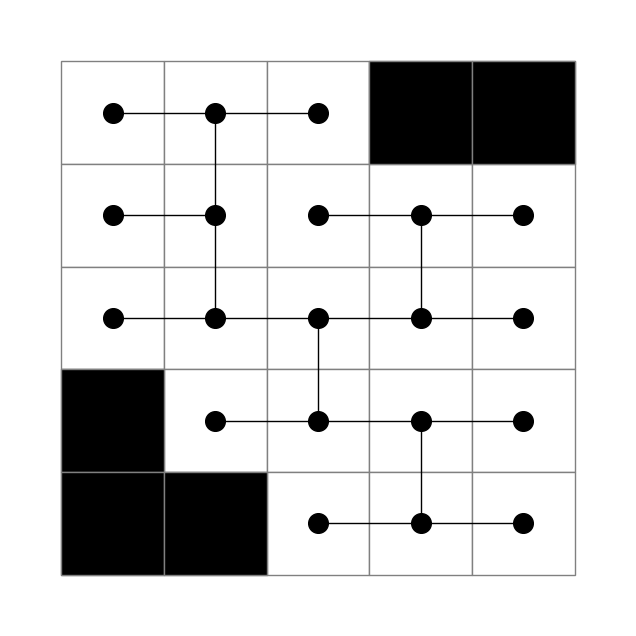

Circuit Model 2: 
|V| =  20  |E| =  30
Best Upper Bound: 19.0
Best Lower Bound: 19.0
Optimality Gap: 0.00%
Time:  0.015922069549560547
 


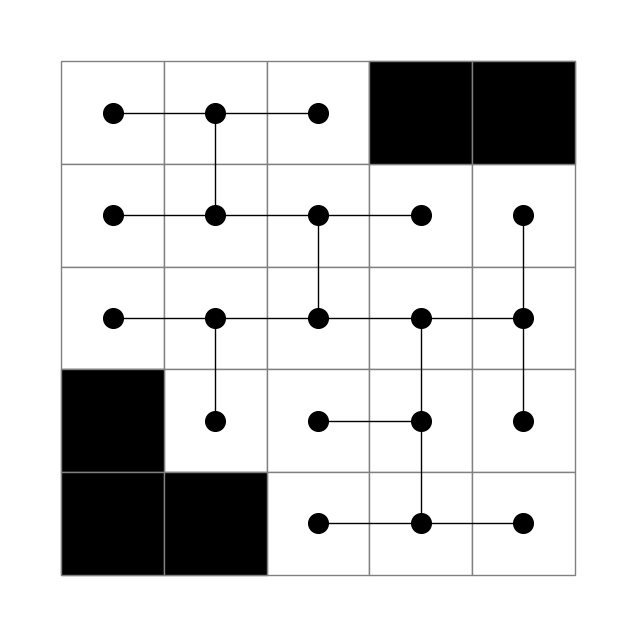

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  34  |E| =  56
Best Upper Bound: 33.0
Best Lower Bound: 33.0
Optimality Gap: 0.00%
Time:  0.04712057113647461
 


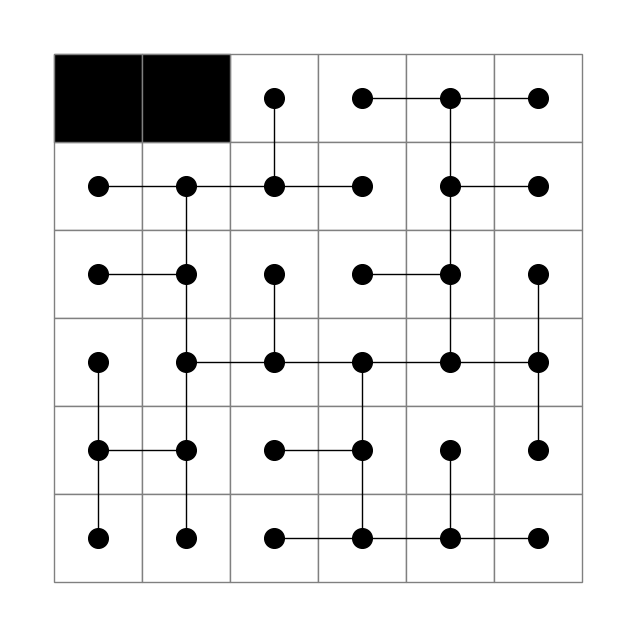

Circuit Model 2: 
|V| =  34  |E| =  56
Best Upper Bound: 33.0
Best Lower Bound: 33.0
Optimality Gap: 0.00%
Time:  0.6914637088775635
 


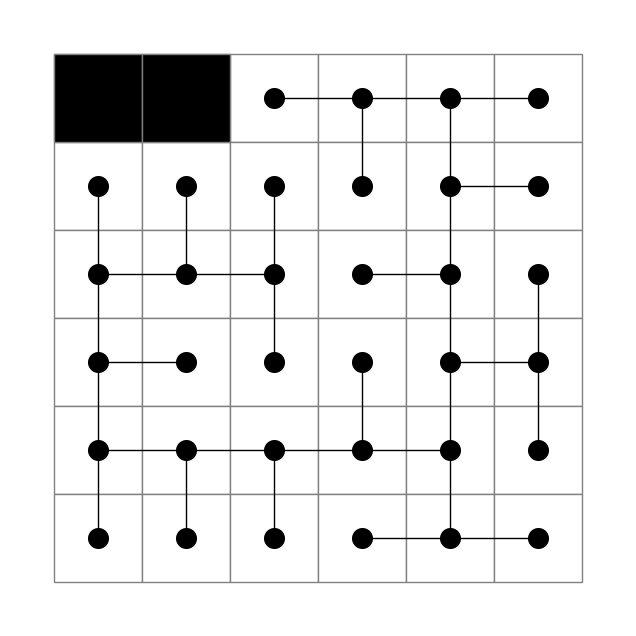

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  30  |E| =  49
Best Upper Bound: 29.0
Best Lower Bound: 29.0
Optimality Gap: 0.00%
Time:  0.031865835189819336
 


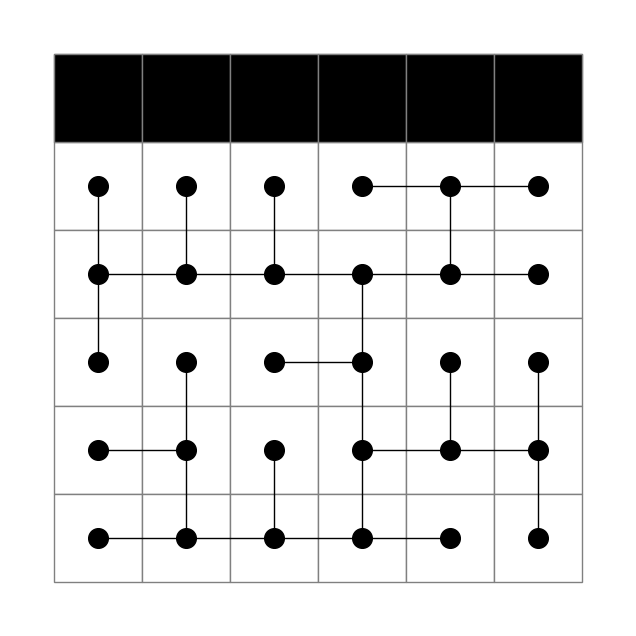

Circuit Model 2: 
|V| =  30  |E| =  49
Best Upper Bound: 29.0
Best Lower Bound: 29.0
Optimality Gap: 0.00%
Time:  0.23531055450439453
 


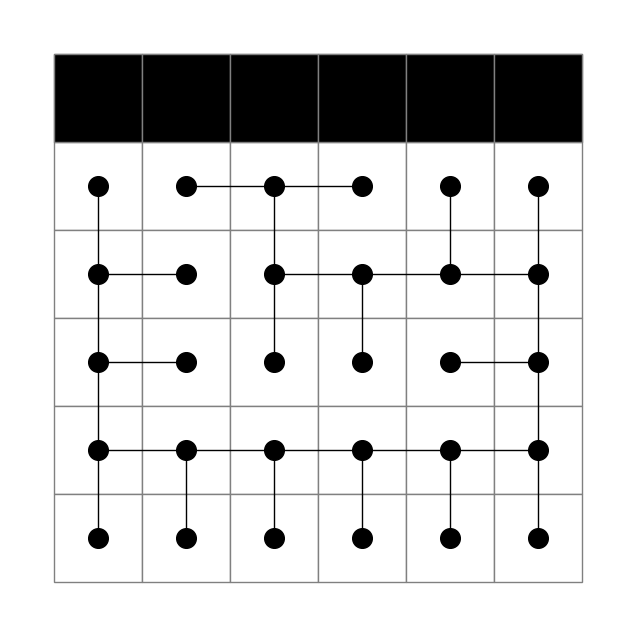

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  32  |E| =  51
Best Upper Bound: 31.0
Best Lower Bound: 31.0
Optimality Gap: 0.00%
Time:  0.04077410697937012
 


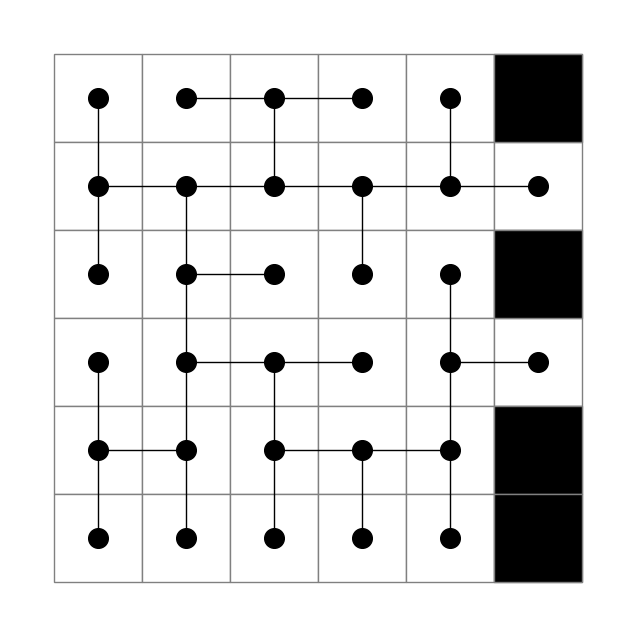

Circuit Model 2: 
|V| =  32  |E| =  51
Best Upper Bound: 31.0
Best Lower Bound: 31.0
Optimality Gap: 0.00%
Time:  0.25124311447143555
 


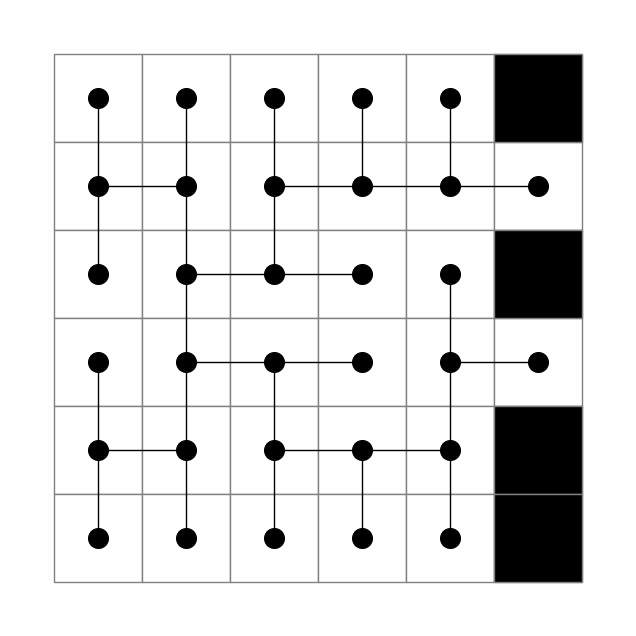

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  30  |E| =  48
Best Upper Bound: 29.0
Best Lower Bound: 29.0
Optimality Gap: 0.00%
Time:  0.03127861022949219
 


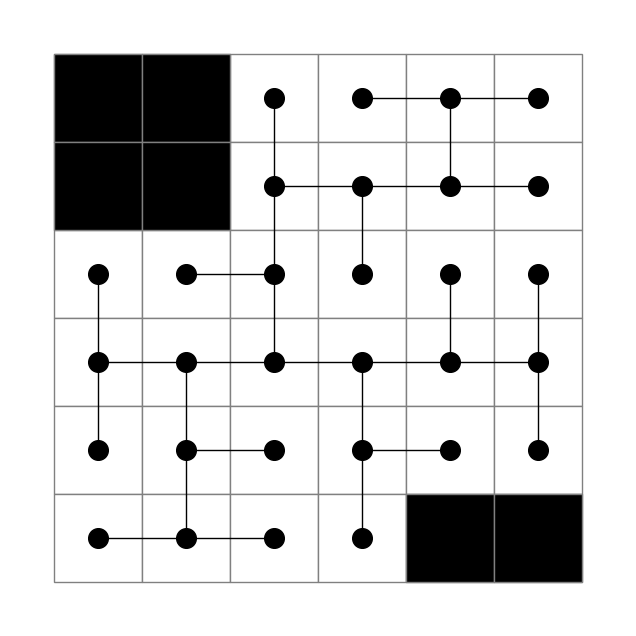

Circuit Model 2: 
|V| =  30  |E| =  48
Best Upper Bound: 29.0
Best Lower Bound: 29.0
Optimality Gap: 0.00%
Time:  0.18850350379943848
 


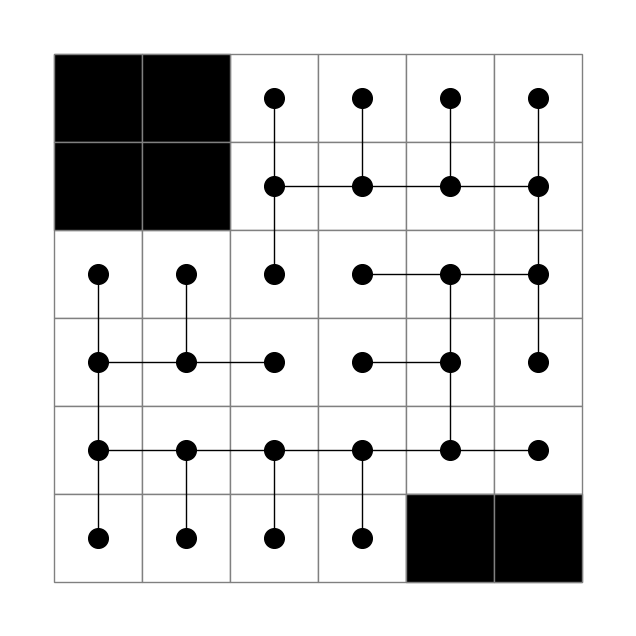

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  34  |E| =  53
Best Upper Bound: 33.0
Best Lower Bound: 33.0
Optimality Gap: 0.00%
Time:  0.0312502384185791
 


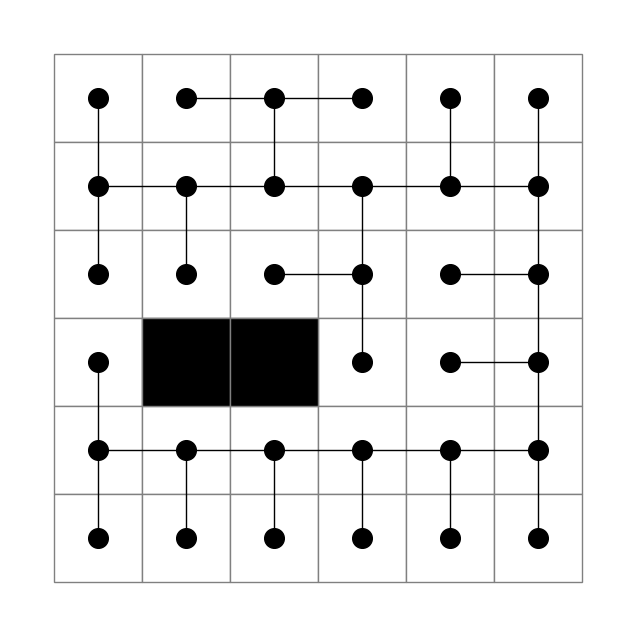

Circuit Model 2: 
|V| =  34  |E| =  53
Best Upper Bound: 33.0
Best Lower Bound: 33.0
Optimality Gap: 0.00%
Time:  0.14169788360595703
 


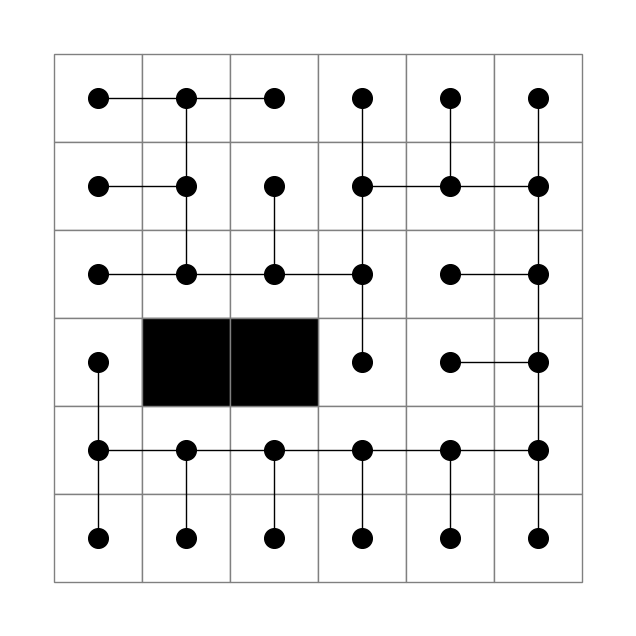

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  42  |E| =  71
Best Upper Bound: 41.0
Best Lower Bound: 41.0
Optimality Gap: 0.00%
Time:  0.07116007804870605
 


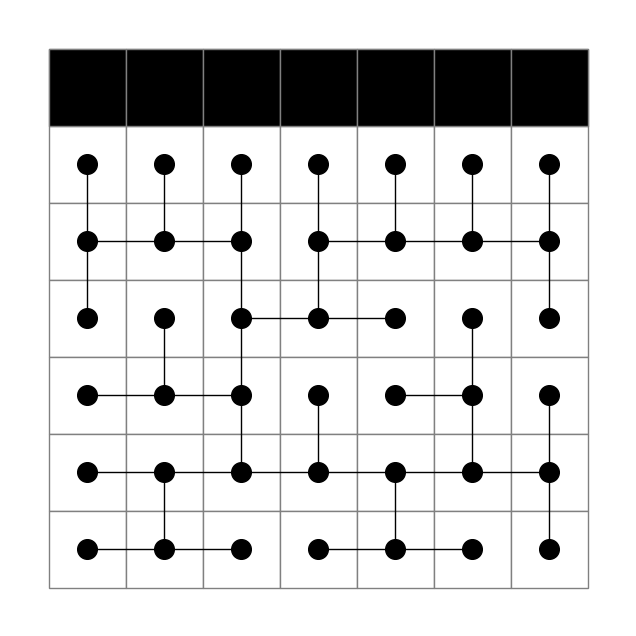

Circuit Model 2: 
|V| =  42  |E| =  71
Best Upper Bound: 41.0
Best Lower Bound: 41.0
Optimality Gap: 0.00%
Time:  14.105506658554077
 


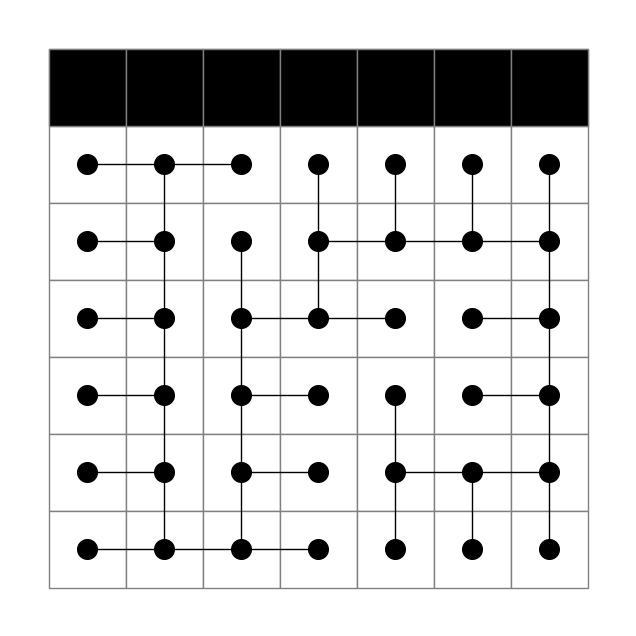

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  48  |E| =  81
Best Upper Bound: 47.0
Best Lower Bound: 47.0
Optimality Gap: 0.00%
Time:  0.15768861770629883
 


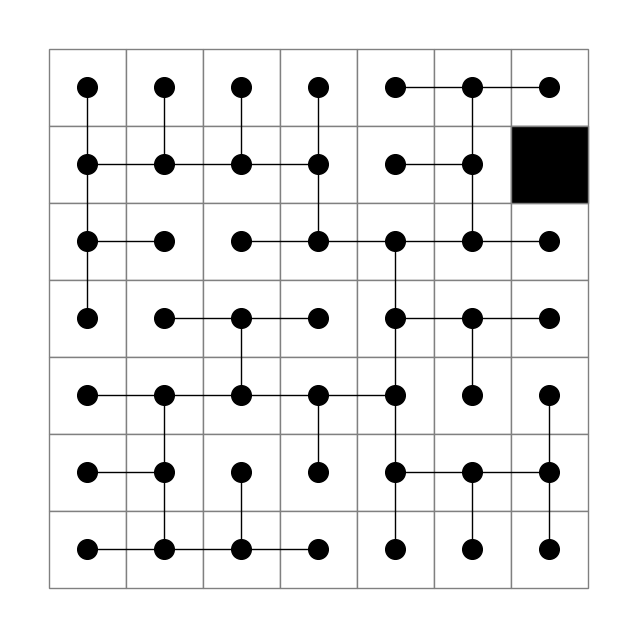

Circuit Model 2: 
|V| =  48  |E| =  81
Best Upper Bound: 47.0
Best Lower Bound: 47.0
Optimality Gap: 0.00%
Time:  61.6456253528595
 


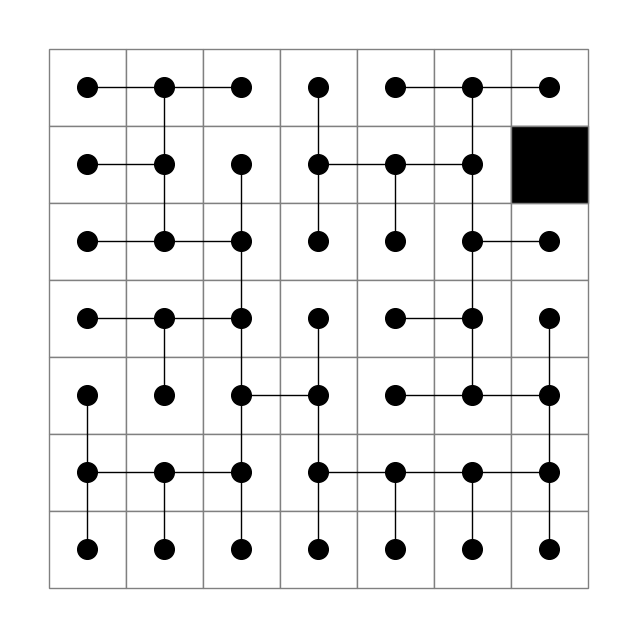

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  44  |E| =  70
Best Upper Bound: 43.0
Best Lower Bound: 43.0
Optimality Gap: 0.00%
Time:  0.10419797897338867
 


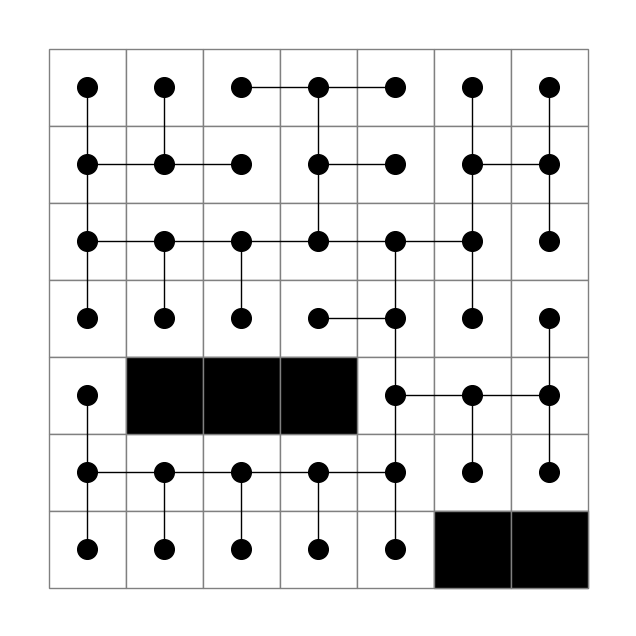

Circuit Model 2: 
|V| =  44  |E| =  70
Best Upper Bound: 43.0
Best Lower Bound: 43.0
Optimality Gap: 0.00%
Time:  0.6459090709686279
 


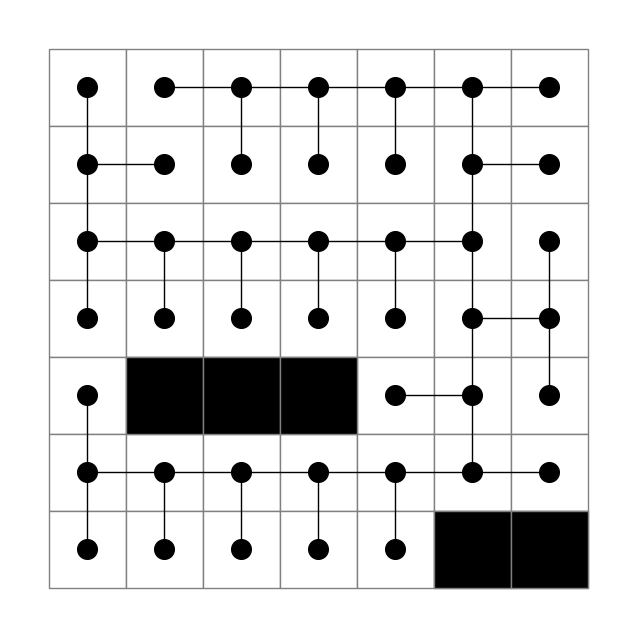

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  46  |E| =  78
Best Upper Bound: 45.0
Best Lower Bound: 45.0
Optimality Gap: 0.00%
Time:  0.09781575202941895
 


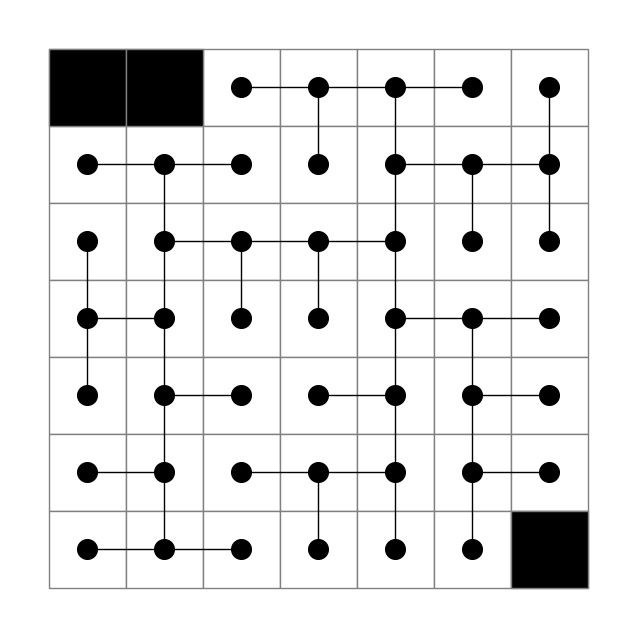

Circuit Model 2: 
|V| =  46  |E| =  78
Best Upper Bound: 45.0
Best Lower Bound: 45.0
Optimality Gap: 0.00%
Time:  54.99127793312073
 


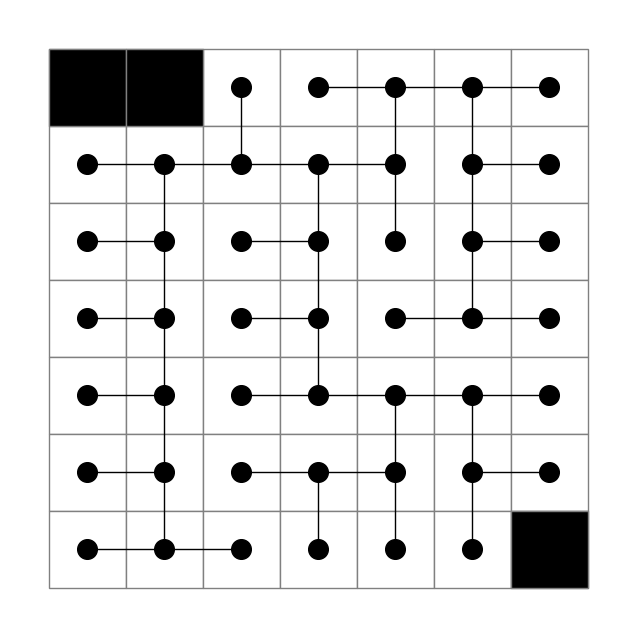

-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  42  |E| =  67
Best Upper Bound: 40.99999999999999
Best Lower Bound: 41.0
Optimality Gap: 0.00%
Time:  0.09496808052062988
 


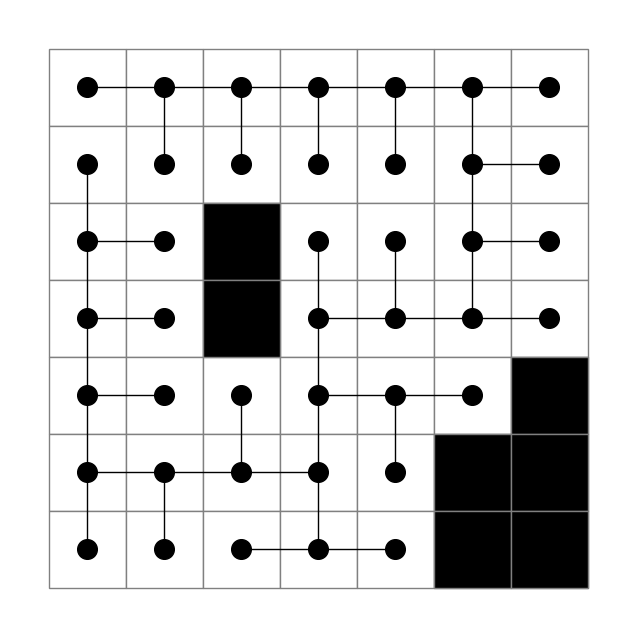

Circuit Model 2: 
|V| =  42  |E| =  67
Best Upper Bound: 41.0
Best Lower Bound: 41.0
Optimality Gap: 0.00%
Time:  1.0584781169891357
 


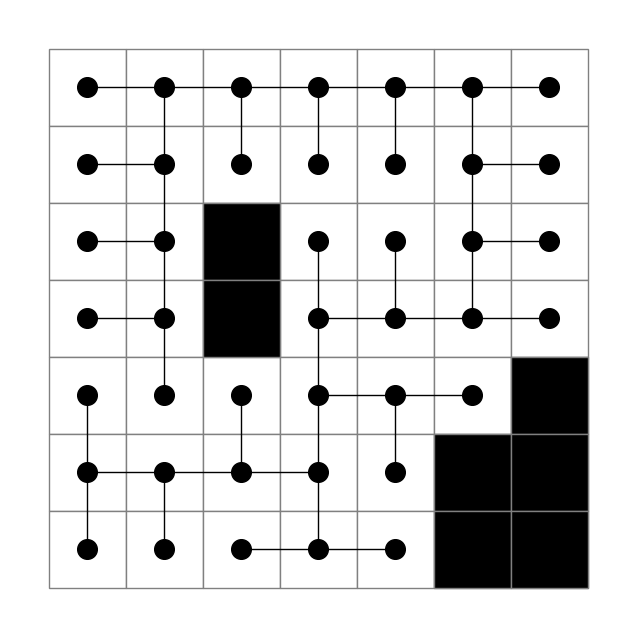

-----------------------------------------------------------------------------------


In [11]:
for i in range(25):  
    print("Circuit Model 1: ")
    solution_edges = solvecircuit(n[i], blank[i], given_edges[i])
    graphcircuit(n[i], blank[i], solution_edges)

    print("Circuit Model 2: ")
    solution_edges = NEOScircuit(n[i], blank[i], given_edges[i])
    graphcircuit(n[i], blank[i], solution_edges)

    print("-----------------------------------------------------------------------------------")

In [11]:
for i in range(25,30):  
    print("Circuit Model 1: ")
    solvecircuit(n[i], blank[i], given_edges[i])

    print("Circuit Model 2: ")
    NEOScircuit(n[i], blank[i], given_edges[i])

    print("-----------------------------------------------------------------------------------")

Circuit Model 1: 
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-07
|V| =  62  |E| =  108
Best Upper Bound: 61.0
Best Lower Bound: 61.0
Optimality Gap: 0.00%
Time:  0.41871118545532227
 
Circuit Model 2: 
|V| =  62  |E| =  108
Best Upper Bound: 61.0
Best Lower Bound: 56.0
Optimality Gap: 8.20%
Time:  1800.0612337589264
 
-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  62  |E| =  108
Best Upper Bound: 61.0
Best Lower Bound: 61.0
Optimality Gap: 0.00%
Time:  0.6483776569366455
 
Circuit Model 2: 
|V| =  62  |E| =  108
Best Upper Bound: 61.0
Best Lower Bound: 57.0
Optimality Gap: 6.56%
Time:  1800.093561887741
 
-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  58  |E| =  94
Best Upper Bound: 57.0
Best Lower Bound: 57.0
Optimality Gap: 0.00%
Time:  0.37946581840515137
 
Circuit Model 2: 
|V| =  58  |E| =  94
Best Upper Bound: 57.0

In [9]:
for i in range(30,35):  
    print("Circuit Model 1: ")
    solvecircuit(n[i], blank[i], given_edges[i])

    print("Circuit Model 2: ")
    NEOScircuit(n[i], blank[i], given_edges[i])

    print("-----------------------------------------------------------------------------------")

Circuit Model 1: 
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-07
|V| =  76  |E| =  134
Best Upper Bound: 75.0
Best Lower Bound: 75.0
Optimality Gap: 0.00%
Time:  1.0910134315490723
 
Circuit Model 2: 
|V| =  76  |E| =  134
Best Upper Bound: 75.0
Best Lower Bound: 66.0
Optimality Gap: 12.00%
Time:  1800.1099467277527
 
-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  78  |E| =  138
Best Upper Bound: 77.0
Best Lower Bound: 77.0
Optimality Gap: 0.00%
Time:  1.0396406650543213
 
Circuit Model 2: 
|V| =  78  |E| =  138
Best Upper Bound: 77.0
Best Lower Bound: 67.0
Optimality Gap: 12.99%
Time:  1800.0592753887177
 
-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  78  |E| =  134
Best Upper Bound: 77.0
Best Lower Bound: 77.0
Optimality Gap: 0.00%
Time:  3.7333691120147705
 
Circuit Model 2: 
|V| =  78  |E| =  134
Best Upper Bound: 7

In [9]:
for i in range(35,40):  
    print("Circuit Model 1: ")
    solvecircuit(n[i], blank[i], given_edges[i])

    print("Circuit Model 2: ")
    NEOScircuit(n[i], blank[i], given_edges[i])

    print("-----------------------------------------------------------------------------------")

Circuit Model 1: 
Set parameter Username
Academic license - for non-commercial use only - expires 2025-10-07
|V| =  98  |E| =  176
Best Upper Bound: 97.0
Best Lower Bound: 97.0
Optimality Gap: 0.00%
Time:  10.957118034362793
 
Circuit Model 2: 
|V| =  98  |E| =  176
Best Upper Bound: 97.0
Best Lower Bound: 81.0
Optimality Gap: 16.49%
Time:  1800.07080411911
 
-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  94  |E| =  168
Best Upper Bound: 93.0
Best Lower Bound: 93.0
Optimality Gap: 0.00%
Time:  2.199100971221924
 
Circuit Model 2: 
|V| =  94  |E| =  168
Best Upper Bound: 93.0
Best Lower Bound: 78.0
Optimality Gap: 16.13%
Time:  1800.115193605423
 
-----------------------------------------------------------------------------------
Circuit Model 1: 
|V| =  98  |E| =  173
Best Upper Bound: 97.0
Best Lower Bound: 97.0
Optimality Gap: 0.00%
Time:  4.750277042388916
 
Circuit Model 2: 
|V| =  98  |E| =  173
Best Upper Bound: 97.0
B

# Circuit Model 3

We use the same notation as for Circuit Model 1 with the addition of the variables  $s$ and $t$ as the endpoints of the path. The decision variables are

$$
x_e = \begin{cases}
    1, & \text{ if edge } e \in E \text{  is included in the tree,} \\
    0, & \text{ otherwise, }
\end{cases}
$$
and the auxiliary binary variable
$$
y_i = \begin{cases}
    1, & \text{ if the degree of vertex } i\in V \text{ is } 3, \\
    0, & \text{ if the degree of vertex } i\in V \text{ is } 1,
\end{cases}
$$
and for the shortest path
$$
p_e = \begin{cases}
    1, & \text{ if edge } e \in E \text{  is included in the path connecting $s$ and $t$}, \\
    0, & \text{ otherwise }
\end{cases}
$$
and the auxiliary binary variable
$$
u_i = \begin{cases}
    1, & \text{ if vertex } i \in V \text{  is included in the path connecting $s$ and $t$}, \\
    0, & \text{ otherwise. }
\end{cases}
$$
The formulation is
$$
\begin{alignat}{2}
    \text{minimise} \ & \sum_{e \in E} x_e + \sum_{e \in E} p_e \\
    \text{subject to } & x_e = 1 && \forall e \in H \\
    & \sum_{\{e\in E \ | \ i\in e\}} x_e = 1 + 2y_i && \forall i \in V \\
    & \sum_{e \in E} x_e = |V| -1  \\
    & \sum_{\{e = (i,j) \in E \ | i \in N\}} x_e \leq |N| - 1 \quad && \forall N \subset V, \ \emptyset \neq N \\
    & p_e \leq x_e && \forall e \in E  \\
    & \sum_{\{e\in E \ | \ u\in e\}} p_e = 1 && \forall u \in \{s,t\} \\
    & \sum_{\{e\in E \ | \ i\in e\}} p_e = 2u_i && \forall i \in V \setminus \{s,t\} \\
    & p_e,x_e \in \{0,1\} \ \forall e \in E,  \\
    & u_i,y_i \in \{0,1\} \ \forall i \in V.
\end{alignat}
$$

In [302]:
def shortcircuit(n, blank, given_edges, s, t):
    # Create model
    model = gp.Model('Circuit')

    # Suppress output
    model.setParam('OutputFlag', 0)

    # Create vertices
    V = list(range(1,n**2 + 1))

    # Create a list that contains the feasible edges of G
    def edges(n):
        E = []
        for i in range(n):  
            for j in range(n): 
                current = i * n + j + 1  
                if j < n - 1:  
                    right = i * n + (j + 1) + 1
                    E.append((current, right))
                if i < n - 1:  
                    below = (i + 1) * n + j + 1
                    E.append((current, below))
        return E

    E = edges(n)
    
    # Remove blank vertices and edges
    for b in blank:
        V.remove(b)
        E = [e for e in E if b not in e]
    
    # Number of vertices
    numV = len(V)
    numE = len(E)

    # Create the decision variables
    x = model.addVars(E, vtype=GRB.BINARY, name = 'x')
    
    y = model.addVars(V, vtype=GRB.BINARY, name = 'y')

    p = model.addVars(E, vtype=GRB.BINARY, name = 'p')

    u = model.addVars(V, vtype=GRB.BINARY, name = 'u')
    
    # Objective function minimises the number of edges
    model.setObjective(gp.quicksum(x[e] for e in E) + gp.quicksum(p[e] for e in E), GRB.MINIMIZE)

    # Path is a subset of the tree
    for e in E:
         model.addConstr(p[e] <= x[e], 'c1')

    # Path is connected
    for i in V:
        if i != s and i != t:
            edges = [e for e in E if i in e]
            model.addConstr(gp.quicksum(p[e] for e in edges) == 2*u[i], 'c2')

    # Path connects s to t
    es = [e for e in E if s in e]
    et = [e for e in E if t in e]
    model.addConstr(gp.quicksum(p[e] for e in es) == 1, 'c3')
    model.addConstr(gp.quicksum(p[e] for e in et) == 1, 'c4')
    
    # Turn input into lower bounds to ensure they are included in the solution
    for e in given_edges:
        x[e].lb = 1
    
    # Constraint that requires all vertices have a degree of 1 or 3
    for i in V:
        # Find all edges connected to this vertex
        edges = [e for e in E if i in e]            
        model.addConstr(gp.quicksum(x[e] for e in edges) == 1 + 2*y[i], 'c5')
    
    # One of the constraints that ensure the solution forms a spanning tree; n-1 edges
    model.addConstr(gp.quicksum(x[e] for e in E) == len(V) - 1, 'c6')
    
    # Constraint that ensures that there are no cycles using subtour elimination inequalities using a callback
    def subtour_elimination(model, where):
        if where == GRB.Callback.MIPSOL:
            # Get the current solution
            selected_edges = [e for e in E if model.cbGetSolution(x[e]) > 0.5]
    
            # Find connected components    
            graph = defaultdict(list)
            for u, v in selected_edges:
                graph[u].append(v)
                graph[v].append(u)
    
            visited = set()
            components = []

            # Use breadth first search to detect cycles
            def bfs(node):
                queue = deque([node])
                component = []
                while queue:
                    curr = queue.popleft()
                    if curr not in visited:
                        visited.add(curr)
                        component.append(curr)
                        queue.extend(graph[curr])
                return component
    
            for v in V:
                if v not in visited:
                    components.append(bfs(v))
    
            # Add lazy constraints to stop the detected cycle from being included in the solution
            if len(components) > 1:
                for comp in components:
                    comp_edges = [e for e in E if e[0] in comp and e[1] in comp]
                    model.cbLazy(gp.quicksum(x[e] for e in comp_edges) <= len(comp) - 1)
    
    # Enable lazy constraints
    model.Params.LazyConstraints = 1
    
    # Solve the Circuit board game
    model.optimize(subtour_elimination)
    
    # Output solution
    if model.status == GRB.OPTIMAL:
        solution_edges = [e for e in E if x[e].x > 0.5]
        path = [e for e in E if p[e].x > 0.5]
        pathvertices = [v for v in V if u[v].x > 0.5]

        print('Feasible')
        
        return solution_edges, path, pathvertices
    else:
        print('Infeasible')

In [36]:
def graphshortcircuit(n, blank, solution_edges, path, pathvertices, s, t):

    # Create vertices
    V = list(range(1,n**2 + 1))
    
    G = nx.Graph()
    pos = {}
        
    # Add nodes and position them using grid coordinates
    for v in V:
        row = (v - 1) // n
        col = (v - 1) % n
        G.add_node(v, pos=(col, -row))  
        pos[v] = (col, -row)
        
    # Add edges from the solution
    G.add_edges_from(solution_edges)
        
    # Create the grid
    plt.figure(figsize=(8, 8))
    ax = plt.gca()
    
    # Draw the grid
    for i in range(n):
        for j in range(n):
            rect = plt.Rectangle((j - 0.5, -i - 0.5), 1, 1, facecolor="white", edgecolor="gray", linewidth=1)
            ax.add_patch(rect)
    
    # Colour the black cells
    for b in blank:
        row = (b - 1) // n
        col = (b - 1) % n
        rect = plt.Rectangle((col - 0.5, -row - 0.5), 1, 1, facecolor="black", edgecolor="gray", linewidth=1)
        ax.add_patch(rect)
    
    # Colour path endpoints blue and path edges and vertices red, all else black
    node_colors = ["red" if v in pathvertices else "blue" if v in {s,t} else "black" for v in G.nodes()]
    edge_colors = ["red" if e in path or (e[1], e[0]) in path else "black" for e in G.edges()]

    # Draw the graph with custom colors
    nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color=edge_colors, node_size=200, font_size=10, width=2)
    
    plt.xlim(-1, n)
    plt.ylim(-n, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

Feasible
[(3, 4), (4, 5), (4, 12), (6, 7), (7, 8), (7, 15), (9, 17), (10, 11), (11, 12), (11, 19), (12, 13), (13, 14), (13, 21), (15, 16), (15, 23), (17, 18), (17, 25), (18, 19), (18, 26), (19, 27), (20, 21), (21, 22), (22, 23), (22, 30), (23, 31), (24, 32), (31, 32), (31, 39), (32, 40), (33, 41), (36, 44), (37, 45), (38, 39), (39, 47), (41, 42), (41, 49), (43, 51), (44, 45), (44, 52), (45, 46), (46, 47), (46, 54), (47, 48), (49, 50), (49, 57), (50, 51), (50, 58), (51, 52), (52, 60), (53, 54), (54, 55), (55, 56), (55, 63), (59, 60), (60, 61), (62, 63), (63, 64)]
[(7, 8), (7, 15), (15, 23), (23, 31), (31, 39), (33, 41), (39, 47), (41, 49), (44, 45), (44, 52), (45, 46), (46, 47), (49, 50), (50, 51), (51, 52)]


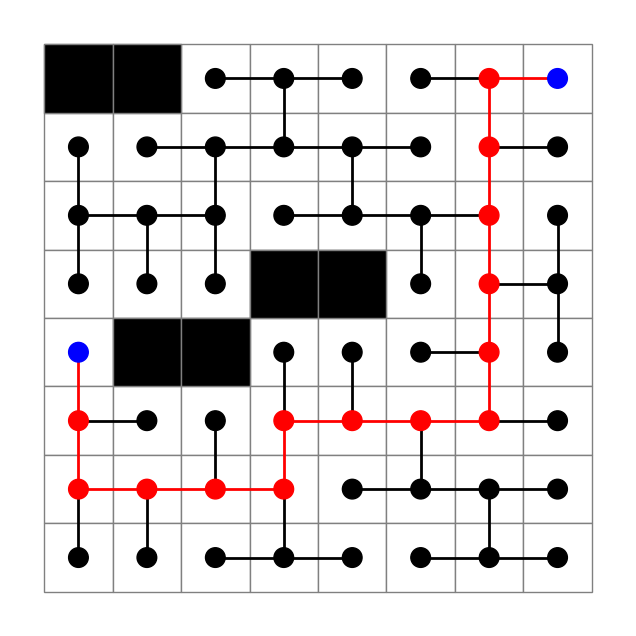

In [304]:
n = 8
blank = [1,2,28,29,34,35]
given_edges = [(11,19),(15,23),(31,39),(33,41),(39,47)]
s = 8
t = 33

solution_edges, path, pathvertices = shortcircuit(n, blank, given_edges, s, t)
print(solution_edges)
print(path)

graphshortcircuit(n, blank, solution_edges, path, pathvertices, s, t)

In [306]:
# Check that a shorter path is infeasible
paths = [[(8,16),(16,24),(17,18),(11,19),(18,19),(19,20),(20,21),(21,22),(15,23),(22,23),(23,24),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(8,16),(15,16),(15,23),(11,19),(17,18),(18,19),(19,20),(20,21),(21,22),(22,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(7,8),(7,15),(17,18),(11,19),(18,19),(19,20),(20,21),(21,22),(15,23),(22,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(7,8),(7,15),(14,15),(14,22),(17,18),(11,19),(18,19),(19,20),(20,21),(21,22),(15,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(6,7),(7,8),(6,14),(14,22),(17,18),(11,19),(18,19),(19,20),(20,21),(21,22),(15,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(6,7),(7,8),(6,14),(13,14),(17,18),(11,19),(13,21),(18,19),(19,20),(20,21),(15,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(5,6),(6,7),(7,8),(5,13),(17,18),(11,19),(13,21),(18,19),(19,20),(20,21),(15,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(5,6),(6,7),(7,8),(5,13),(12,13),(12,20),(17,18),(11,19),(18,19),(19,20),(15,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(4,5),(5,6),(6,7),(7,8),(4,12),(12,20),(17,18),(11,19),(18,19),(19,20),(15,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(4,5),(5,6),(6,7),(7,8),(4,12),(11,12),(17,18),(11,19),(18,19),(15,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(3,4),(4,5),(5,6),(6,7),(7,8),(3,11),(17,18),(11,19),(18,19),(15,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(3,4),(4,5),(5,6),(6,7),(7,8),(3,11),(10,11),(10,18),(17,18),(11,19),(15,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(3,4),(4,5),(5,6),(6,7),(7,8),(3,11),(9,10),(10,11),(9,17),(11,19),(15,23),(17,25),(25,33),(31,39),(33,41),(39,47)],
         [(8,16),(16,24),(11,19),(18,19),(19,20),(20,21),(21,22),(15,23),(22,23),(23,24),(18,26),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(8,16),(16,24),(11,19),(19,20),(20,21),(21,22),(15,23),(22,23),(23,24),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)],
         [(8,16),(15,16),(15,23),(11,19),(18,19),(19,20),(20,21),(21,22),(15,23),(22,23),(18,26),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(8,16),(15,16),(15,23),(11,19),(19,20),(20,21),(21,22),(15,23),(22,23),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)],
         [(7,8),(7,15),(11,19),(18,19),(19,20),(20,21),(21,22),(15,23),(18,26),(22,23),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(7,8),(7,15),(11,19),(19,20),(20,21),(21,22),(15,23),(22,23),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)],
         [(7,8),(7,15),(14,15),(14,22),(11,19),(18,19),(19,20),(20,21),(21,22),(15,23),(18,26),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(7,8),(7,15),(14,15),(14,22),(11,19),(19,20),(20,21),(21,22),(15,23),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)],
         [(6,7),(7,8),(6,14),(14,22),(11,19),(18,19),(19,20),(20,21),(21,22),(15,23),(18,26),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(6,7),(7,8),(6,14),(14,22),(11,19),(19,20),(20,21),(21,22),(15,23),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)],
         [(6,7),(7,8),(6,14),(13,14),(11,19),(13,21),(18,19),(19,20),(20,21),(15,23),(18,26),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(6,7),(7,8),(6,14),(13,14),(11,19),(13,21),(19,20),(20,21),(15,23),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)],
         [(5,6),(6,7),(7,8),(5,13),(11,19),(13,21),(18,19),(19,20),(20,21),(15,23),(18,26),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(5,6),(6,7),(7,8),(5,13),(11,19),(13,21),(19,20),(20,21),(15,23),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)],
         [(5,6),(6,7),(7,8),(5,13),(12,13),(12,20),(11,19),(18,19),(19,20),(15,23),(18,26),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(5,6),(6,7),(7,8),(5,13),(12,13),(12,20),(11,19),(19,20),(15,23),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)],
         [(4,5),(5,6),(6,7),(7,8),(4,12),(12,20),(11,19),(18,19),(19,20),(15,23),(18,26),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(4,5),(5,6),(6,7),(7,8),(4,12),(12,20),(11,19),(19,20),(15,23),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)],
         [(4,5),(5,6),(6,7),(7,8),(4,12),(11,12),(11,19),(18,19),(15,23),(18,26),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(4,5),(5,6),(6,7),(7,8),(4,12),(11,12),(11,19),(15,23),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)],
         [(3,4),(4,5),(5,6),(6,7),(7,8),(3,11),(11,19),(18,19),(15,23),(18,26),(25,26),(25,33),(31,39),(33,41),(39,47)],
         [(3,4),(4,5),(5,6),(6,7),(7,8),(3,11),(11,19),(15,23),(19,27),(25,26),(26,27),(25,33),(31,39),(33,41),(39,47)]]

for p in paths:
    shortcircuit(n, blank, p, s, t)

Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible
Infeasible


# Problem Graphs
Display the unsolved puzzles

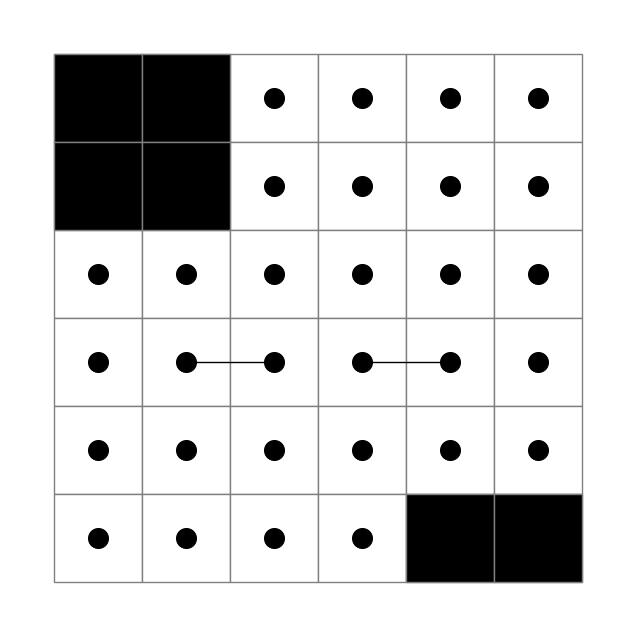

In [38]:
n = 6
blank = [1,2,7,8,35,36]
given_edges = [(20,21),(22,23)]

# Create vertices
V = list(range(1,n**2 + 1))

# Display the basic circuit problem
G = nx.Graph()
pos = {}
    
# Add nodes and position them using grid coordinates
for v in V:
    row = (v - 1) // n
    col = (v - 1) % n
    G.add_node(v, pos=(col, -row))
    pos[v] = (col, -row)
    
# Add given edges
G.add_edges_from(given_edges)
    
# Plot the grid
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Draw the grid
for i in range(n):
    for j in range(n):
        rect = plt.Rectangle((j - 0.5, -i - 0.5), 1, 1, facecolor="white", edgecolor="gray", linewidth=1)
        ax.add_patch(rect)

# Colour the blank squares black
for b in blank:
    row = (b - 1) // n
    col = (b - 1) % n
    rect = plt.Rectangle((col - 0.5, -row - 0.5), 1, 1, facecolor="black", edgecolor="gray", linewidth=1)
    ax.add_patch(rect)

# Draw the graph
nx.draw(G, pos, with_labels=False, node_color="black", edge_color="black", node_size=200, font_size=10)
plt.xlim(-1, n)
plt.ylim(-n, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

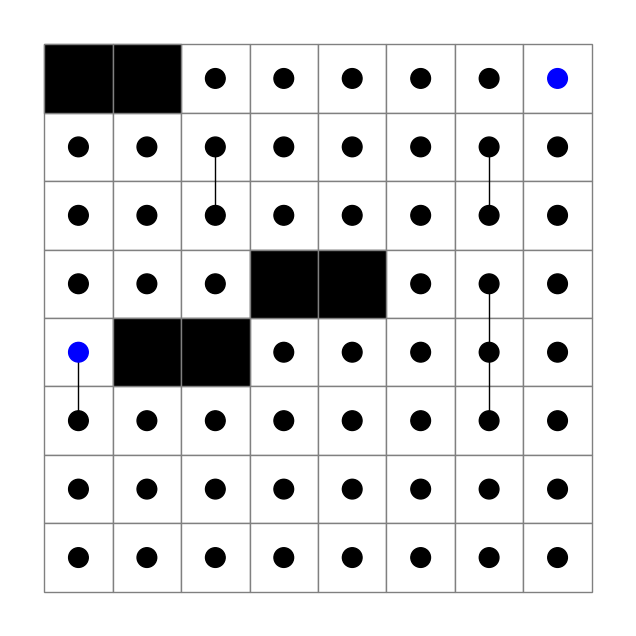

In [274]:
n = 8
blank = [1,2,28,29,34,35]
given_edges = [(11,19),(15,23),(31,39),(33,41),(39,47)]
s = 8
t = 33

# Create vertices
V = list(range(1,n**2 + 1))

# Display the basic circuit problem
G = nx.Graph()
pos = {}
    
# Add nodes and their positions based on grid coordinates
for v in V:
    row = (v - 1) // n
    col = (v - 1) % n
    G.add_node(v, pos=(col, -row)) 
    pos[v] = (col, -row)
    
# Add given edges
G.add_edges_from(given_edges)
    
# Plot the grid with blank squares
plt.figure(figsize=(8, 8))
ax = plt.gca()

# Draw the grid background
for i in range(n):
    for j in range(n):
        rect = plt.Rectangle((j - 0.5, -i - 0.5), 1, 1, facecolor="white", edgecolor="gray", linewidth=1)
        ax.add_patch(rect)

# Color the blank squares black
for b in blank:
    row = (b - 1) // n
    col = (b - 1) % n
    rect = plt.Rectangle((col - 0.5, -row - 0.5), 1, 1, facecolor="black", edgecolor="gray", linewidth=1)
    ax.add_patch(rect)

# Colour endpoints blue
node_colors = ["blue" if v in {s,t} else "black" for v in G.nodes()]

# Draw the graph
nx.draw(G, pos, with_labels=False, node_color=node_colors, edge_color="black", node_size=200, font_size=10)
plt.xlim(-1, n)
plt.ylim(-n, 1)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Linear Relaxation Objective Values

In [54]:
def solvecircuitLR(n, blank, given_edges):
    # Create model
    model = gp.Model('Circuit')

    # Suppress output
    model.setParam('OutputFlag', 0)

    # Set time limit
    model.setParam(GRB.Param.TimeLimit, 1800)

    # Create vertices
    V = list(range(1,n**2 + 1))

    # Create a list that contains the feasible edges of G
    def edges(n):
        E = []
        for i in range(n):
            for j in range(n):
                current = i * n + j + 1
                if j < n - 1:
                    right = i * n + (j + 1) + 1
                    E.append((current, right))
                if i < n - 1:
                    below = (i + 1) * n + j + 1
                    E.append((current, below))
        return E

    E = edges(n)
    
    # Remove blank vertices and edges
    for b in blank:
        V.remove(b)
        E = [e for e in E if b not in e]
    
    # Number of vertices
    numV = len(V)
    numE = len(E)

    # Create the decision variables
    x = model.addVars(E, vtype=GRB.CONTINUOUS, name = 'x')
    
    y = model.addVars(V, vtype=GRB.CONTINUOUS, name = 'y')
    
    # Objective function is to minimise number of edges
    model.setObjective(gp.quicksum(x[e] for e in E), GRB.MINIMIZE)
    
    # Turn input into lower bounds to ensure they are included in the solution
    for e in given_edges:
        x[e].lb = 1
    
    # Constraint that requires all vertices have a degree of 1 or 3
    for i in V:
        # Find all edges connected to this vertex
        edges = [e for e in E if i in e]            
        model.addConstr(gp.quicksum(x[e] for e in edges) == 1 + 2*y[i], 'c1')
    
    # One of the constraints that ensure the solution forms a spanning tree: n-1 edges
    model.addConstr(gp.quicksum(x[e] for e in E) == len(V) - 1, 'c2')
    
    # Constraint that ensures that there are no cycles using subtour elimination inequalities using a callback
    def subtour_elimination(model, where):
        if where == GRB.Callback.MIPSOL:
            # Get the current solution
            selected_edges = [e for e in E if model.cbGetSolution(x[e]) > 0.5]
    
            # Find connected components    
            graph = defaultdict(list)
            for u, v in selected_edges:
                graph[u].append(v)
                graph[v].append(u)
    
            visited = set()
            components = []

            # Use breadth first search to detect cycles
            def bfs(node):
                queue = deque([node])
                component = []
                while queue:
                    curr = queue.popleft()
                    if curr not in visited:
                        visited.add(curr)
                        component.append(curr)
                        queue.extend(graph[curr])
                return component
    
            for v in V:
                if v not in visited:
                    components.append(bfs(v))
    
            # Add lazy constraints to stop the detected cycle from being included in the solution
            if len(components) > 1:
                for comp in components:
                    comp_edges = [e for e in E if e[0] in comp and e[1] in comp]
                    model.cbLazy(gp.quicksum(x[e] for e in comp_edges) <= len(comp) - 1)
    
    # Enable lazy constraints
    model.Params.LazyConstraints = 1
    
    # Solve the Circuit board game
    model.optimize(subtour_elimination)
    
    # Output solution
    print("|V| = ", numV, " |E| = ", numE)
    
    if model.status == GRB.OPTIMAL:
        solution_edges = [e for e in E if x[e].x > 0.5]

    # Extract results
    if model.SolCount > 0:
        best_upper_bound = model.ObjVal
        print(f"Objective Value: {best_upper_bound}")
    
    print(" ")

In [56]:
def NEOScircuitLR(n, blank, given_edges):    
    # Create model
    model = gp.Model('NEOSModel')

    # Suppress output
    model.setParam('OutputFlag', 0)

    # Set time limit
    model.setParam(GRB.Param.TimeLimit, 1800)

    # Create vertices
    V = list(range(1,n**2 + 1))

    # Big-M variable, chosen using justification provided in the report
    M = 99
    
    # Generate all edges
    def edges(n):
        A = []
        for i in range(n):
            for j in range(n): 
                current = i * n + j + 1
                if j < n - 1:
                    right = i * n + (j + 1) + 1
                    A.append((current, right))
                if i < n - 1:
                    below = (i + 1) * n + j + 1
                    A.append((current, below))
        return A
    
    E = edges(n)
    
    # Remove blocked arcs
    for b in blank:
        V.remove(b)
        E = [e for e in E if b not in e]

    numV = len(V)
    numE = len(E)
    
    # Reverse order to represent the flow of each arc
    def reverseTuple(E):
        return [tup[::-1] for tup in E]
    
    Einv = reverseTuple(E)

    # Define all arcs 
    A = E.copy()
    for a in Einv:
        A.append(a)
    
    def generate_S(n, blank):
        total_cells = n**2

        # All but one vertex has supply vertex -1
        S = {v: -1 for v in range(1, total_cells + 1)}  
    
        # Blocked cells have supply 0
        for b in blank:
            S[b] = 0
    
        # Set up the source vertex
        unblocked_cells = [v for v in range(1, total_cells + 1) if v not in blank]
        if unblocked_cells:
            source_vertex = unblocked_cells[0]
            S[source_vertex] = len(unblocked_cells) - 1
        return S
    
    S = generate_S(n, blank)
    
    # Decision variables
    x = model.addVars(A, vtype=GRB.CONTINUOUS, name="x")
    z = model.addVars(E, vtype=GRB.CONTINUOUS, name="z")
    t = model.addVars(V, vtype=GRB.CONTINUOUS, name="t")
    
    # Objective function is to minimise number of edges
    model.setObjective(gp.quicksum(z[e] for e in E), GRB.MINIMIZE)
    
    # Flow conservation equations
    for i in V:
        a = gp.quicksum(x[arc] for arc in A if arc[0] == i)
        b = gp.quicksum(x[arc] for arc in A if arc[1] == i)
        model.addConstr(a - b == S[i], 'c1')
    
    
    # Relate arcs to edges. Edges must be turned on if flow is passing through as assosiated arc
    for e in E:
        model.addConstr(x[e] + x[e[1], e[0]] <= z[e] * M, 'c2')
        model.addConstr(M*(x[e] + x[e[1], e[0]]) >= z[e] , 'c3')
    
    
    # Ensure each vertex has degree either 1 or 3
    for i in V:
        # Find all edges connected to this vertex
        edges = [e for e in E if i in e]
        model.addConstr(gp.quicksum(z[e] for e in edges) == 1 + 2 * t[i], 'c4')
    
    
    # Given edges set as lower bounds
    for e in given_edges:
        z[e].lb = 1
    
    # Solve model
    model.optimize()
    
    # Output solution
    print("|V| = ", numV, " |E| = ", numE)
    
    if model.status == GRB.OPTIMAL:
        solution_edges = [e for e in E if z[e].x > 0.5]

    # Extract results
    if model.SolCount > 0:
        best_upper_bound = model.ObjVal
        print(f"Objective Value: {best_upper_bound}")
    
    print(" ")

In [58]:
# Initialize input
n = [3,4,5,6,7,8,9,10]
blank = [[1,2,3],
         [3,4],
         [16,21,25],
         [1,2],
         [1,2,3,4,5,6,7],
         [1,8],
         [1,2,10,80,81],
         [99,100]]
given_edges = [[(8,9)],
               [(7,11),(10,11)],
               [(9,14),(14,15)],
               [(15,21),(22,28)],
               [(14,21)],
               [(35,36)],
               [(9,18)],
               [(1,11)]] 

In [62]:
for i in range(8):  
    print("Circuit Model 1: ")
    solvecircuitLR(n[i], blank[i], given_edges[i])

    print("Circuit Model 2: ")
    NEOScircuitLR(n[i], blank[i], given_edges[i])
    print('------------------------------------------')

Circuit Model 1: 
|V| =  6  |E| =  7
Objective Value: 5.0
 
Circuit Model 2: 
|V| =  6  |E| =  7
Objective Value: 3.0202020202020203
 
------------------------------------------
Circuit Model 1: 
|V| =  14  |E| =  20
Objective Value: 13.0
 
Circuit Model 2: 
|V| =  14  |E| =  20
Objective Value: 7.999999999999989
 
------------------------------------------
Circuit Model 1: 
|V| =  22  |E| =  34
Objective Value: 21.0
 
Circuit Model 2: 
|V| =  22  |E| =  34
Objective Value: 11.999999999999982
 
------------------------------------------
Circuit Model 1: 
|V| =  34  |E| =  56
Objective Value: 33.0
 
Circuit Model 2: 
|V| =  34  |E| =  56
Objective Value: 17.020202020202017
 
------------------------------------------
Circuit Model 1: 
|V| =  42  |E| =  71
Objective Value: 41.0
 
Circuit Model 2: 
|V| =  42  |E| =  71
Objective Value: 21.010101010101064
 
------------------------------------------
Circuit Model 1: 
|V| =  62  |E| =  108
Objective Value: 61.0
 
Circuit Model 2: 
|V| =  62